<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/research/trend-momentum-spot-analysis/update_2023/2a_updated_Cross_Sectional_Momentum_Binance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2a Cross-Sectional Momentum using Binance Data - Updated 2023

In this notebook we do factor analysis on simple momentum factors using Binance data.

We find that because our Coincodex price data is a VWAP aggregated from many sources, we see a strong day-ahead reversal effect that we'd not be able to trade.

We make a new function for creating a universe from our Binance price data and the Coincodex market cap data, discarding the untradable Coincodex price data.

We find a strong, persistent and robust cross-sectional momentum effect when we analyse the data in this way.

## Load libraries and authenticate

In [ ]:
# snippet: rw load rwRtools v0.8
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
debug_msg <- load_libraries(load_rsims = FALSE, extra_libraries = c('lubridate', 'RcppRoll', 'QuantTools'), extra_dependencies = c('RcppParallel'))

# cat(debug_msg)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Using 2  CPUs for package installation

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘QuantTools’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
Warning message in pacman::p_load(char = libs_to_load, install = FALSE):
“Failed to install/load:
QuantTools”


── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpXO2Q0v/remotes11456946856/RWLab-rwRtools-f742350/DESCRIPTION’ ... OK
* preparing ‘rwRtools’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘rwRtools_0.1.53.tar.gz’



In [ ]:
# snippet: rw data auth v.0.1
rwlab_data_auth()

Authorization successful!

## Load Coincodex daily data

For getting market cap info

In [ ]:
# snippet: rw crypto load coincodex data v0.1
cc_prices <- rwRtools::crypto_get_coincodex()
cc_prices %>%
  head()

ℹ Downloading coincodex_marketcap.feather

✔ Saved coincodex_marketcap.feather to coincodex/coincodex_marketcap.feather  (…





File successfully transferred


Ticker,Date,Price,Volume,MarketCapUSD
<chr>,<date>,<dbl>,<dbl>,<dbl>
BTCD,2017-01-01,3.500750e+00,2.141424e+03,4.513253e+06
TGC,2017-01-01,3.355230e-04,1.809028e+01,1.461090e+04
ATOM,2017-01-02,1.210969e-02,5.763597e+03,9.059482e+04
BTC,2017-01-02,1.016241e+03,1.871437e+08,1.634320e+10
BTCD,2017-01-02,3.389330e+00,2.864861e+03,4.516087e+06
DASH,2017-01-02,1.156342e+01,3.853539e+06,8.113380e+07


# Creating research universe

See Notebook 1 for details on how we construct the universe.

In [ ]:
# snippet: rw crypto flag universe consituents v0.2
create_universe <- function(prices, n=10, min_constituents=10, stables, duplicates) {
  # Remove stablecoins and duplicates
  prices <- prices %>%
    filter(!Ticker %in% c(stables, duplicates))

  # Fix bad BCH data
  # 1. make a dataframe of updated rows
  updated_rows <- prices %>%
    filter(Ticker == "BCH") %>%
    # find rows where the price today is more than twice the price from the day before and from the day after
    mutate(
      lag_price = dplyr::lag(Price),
      lead_price = dplyr::lead(Price)
    ) %>%
    filter(
      # 0.65 found by trial and error to isolate the rows we want to ditch
      lag_price < 0.65*Price,
      lead_price < 0.65*Price
    ) %>%
    # set today's price to half way between yesterday's and tomorrow's price
    mutate(Price = lag_price + (lead_price - lag_price)/2) %>%
    # select only the columns that were in our original prices dataframe
    select(Ticker, Date, Price, Volume, MarketCapUSD)

  # 2. remove the bad rows from our original prices dataframe
  prices <- prices %>%
    filter(!(Ticker == "BCH" & Date %in% (updated_rows %>% pull(Date))))

  # 3. merge our prices dataframe with our updated rows and sort
  prices <- prices %>%
    bind_rows(updated_rows) %>%
    arrange(Date, Ticker)

  # Fix dates where something went wrong with the data
  # 1. Get weird dates
  weird_dates <- prices %>%
    group_by(Date) %>%
    summarise(count = n()) %>%
    mutate(lag_count = dplyr::lag(count)) %>%
    filter(count < 0.8*lag_count) %>%
    pull(Date)

  # 2. Create new dataframe from the dates prior to our weird dates, then label them as our weird dates
  prices_new <- prices %>%
    filter(Date %in% as.Date(weird_dates - 1)) %>%
    mutate(Date = Date + 1)

  # 3. Filter out these weird rows
  prices <- prices %>%
    filter(!Date %in% as.Date(weird_dates))

  # 4. Combine the two dataframes
  prices <- prices %>%
    bind_rows(prices_new) %>%
    arrange(Date, Ticker)

  # Get first date where we have min_constituents
  start_date <- prices %>%
    group_by(Date) %>%
    summarise(count = n()) %>%
    filter(count >= min_constituents) %>%
    summarise(mindate = min(Date)) %>%
    pull(mindate)

  start_date <- start_date + 1

  # Flag universe consitutents
  # For a given ticker/date observation, set is_index to TRUE if:
  #    - the asset was in the top 10 coins by market cap the day before
  #    - the date is on or after the date when we have min_consituents assets in our dataset
  prices %>%
    group_by(Date) %>%
    mutate(cap_rank = row_number(desc(MarketCapUSD))) %>%
    arrange(Date) %>%
    group_by(Ticker) %>%
    mutate(is_index = lag(cap_rank) <= 10 & Date >= start_date) %>%
    na.omit() %>%
    ungroup()
}


# list of stablecoins from defi llama
url <- "https://stablecoins.llama.fi/stablecoins?includePrices=true"
response <- httr::GET(url)

stables <- response %>%
  content(as = "text", encoding = "UTF-8") %>%
  jsonlite::fromJSON(flatten = TRUE) %>%
  pluck("peggedAssets") %>%
  pull(symbol)

duplicates <-  c('BTCD', 'HBTC', 'IBBTC', 'RBTC', 'SBTC3', 'WNXM', 'WBTC')

# create universe
universe <- create_universe(cc_prices, n=10, min_constituents=10, stables=stables, duplicates=duplicates)

universe %>% head

Ticker,Date,Price,Volume,MarketCapUSD,cap_rank,is_index
<chr>,<date>,<dbl>,<dbl>,<dbl>,<int>,<lgl>
TGC,2017-01-01,3.355230e-04,1.809028e+01,1.461090e+04,1,FALSE
ATOM,2017-01-02,1.210969e-02,5.763597e+03,9.059482e+04,23,FALSE
BTC,2017-01-02,1.016241e+03,1.871437e+08,1.634320e+10,1,FALSE
DASH,2017-01-02,1.156342e+01,3.853539e+06,8.113380e+07,7,FALSE
DCR,2017-01-02,4.702788e-01,5.507167e+03,1.638005e+06,20,FALSE
DGB,2017-01-02,2.584741e-04,1.727275e+04,2.012658e+06,19,FALSE


## Load binance hourly spot data

In [ ]:
prices <- rwRtools::crypto_get_binance_spot_1h()
head(prices)

ℹ Downloading binance_spot_1h.feather

✔ Saved binance_spot_1h.feather to binance/binance_spot_1h.feather  ( 757.4 Mb )





File successfully transferred


Ticker,Datetime,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
BTCUSDT,2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,202366.14,171,35.160503,150952.48
ETHUSDT,2017-08-17 04:00:00,301.13,302.57,298.00,301.61,125.668770,37684.80,129,80.563770,24193.44
BTCUSDT,2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,100304.82,102,21.448071,92608.28
ETHUSDT,2017-08-17 05:00:00,301.61,303.28,300.00,303.10,377.672460,114043.28,202,328.104280,99079.80
BTCUSDT,2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,31282.31,36,4.802861,20795.32
ETHUSDT,2017-08-17 06:00:00,302.40,304.44,301.90,302.68,303.866720,92034.44,182,259.286680,78525.95


In [ ]:
# retain only the data we need and ditch USDT part of Ticker
prices <- prices %>%
  select(Ticker, Datetime, Close) %>%
  mutate(Ticker = str_replace(Ticker, "USDT$", ""))

head(prices)

Ticker,Datetime,Close
<chr>,<dttm>,<dbl>
BTC,2017-08-17 04:00:00,4308.83
ETH,2017-08-17 04:00:00,301.61
BTC,2017-08-17 05:00:00,4315.32
ETH,2017-08-17 05:00:00,303.10
BTC,2017-08-17 06:00:00,4324.35
ETH,2017-08-17 06:00:00,302.68


In [ ]:
# take a daily snapshot at a particular time
daily_prices_12 <- prices %>%
  mutate(
    Hour = hour(Datetime),
    Date = as_date(Datetime)
  ) %>%
  filter(Hour == 12) %>%
  select(Date, Ticker, Close)

head(daily_prices_12)

Date,Ticker,Close
<date>,<chr>,<dbl>
2017-08-17,BTC,4411.00
2017-08-17,ETH,308.62
2017-08-18,BTC,4331.71
2017-08-18,ETH,308.47
2017-08-19,BTC,4095.00
2017-08-19,ETH,290.85


In [ ]:
# first day we have ten tickers in binance price data
start_date <- daily_prices_12 %>%
  group_by(Date) %>%
  summarise(count = n()) %>%
  filter(count >= 10) %>%
  head(1) %>%
  pull(Date)

start_date

[1] "2018-05-28"

In [ ]:
universe_join <- universe %>%
  select(Ticker, Date, MarketCapUSD)

binance_universe <- daily_prices_12 %>%
  # this will remove any tickers that were removed from the coincodex data
  left_join(universe_join, by = c("Ticker", "Date")) %>%
  na.omit() %>%
  # but we need to create a new universe based on the remaining binance tickers (not all coincodex tickers were trading on binance)
  group_by(Date) %>%
  mutate(cap_rank = row_number(desc(MarketCapUSD))) %>%
  arrange(Date) %>%
  group_by(Ticker) %>%
  mutate(is_index = lag(cap_rank) <= 10 & Date >= start_date) %>%
  na.omit() %>%
  ungroup()

rm(universe_join)

head(binance_universe)

Date,Ticker,Close,MarketCapUSD,cap_rank,is_index
<date>,<chr>,<dbl>,<dbl>,<int>,<lgl>
2017-08-17,BTC,4411.00,72153449099,1,FALSE
2017-08-17,ETH,308.62,28752742413,2,FALSE
2017-08-18,BTC,4331.71,70206129858,1,FALSE
2017-08-18,ETH,308.47,28406320026,2,FALSE
2017-08-19,BTC,4095.00,67500579074,1,FALSE
2017-08-19,ETH,290.85,27839631816,2,FALSE


# Create Momentum Feature and Forward Returns

Calculate 20 day momentum factor and next day returns.

In [ ]:
returns <- binance_universe %>%
  group_by(Ticker) %>%
  arrange(Date) %>%
  # Calculate 20d momentum feature
  mutate(momo20 = Close / lag(Close, n = 20) - 1,
         lagmomo20 = lag(momo20)) %>%
  # Calculate next day returns
  mutate(fwd_log_return = log(lead(Close) / Close),
         fwd_simple_return = lead(Close) / Close - 1) %>%
  na.omit() %>%
  ungroup()

  returns %>% head(10)

Date,Ticker,Close,MarketCapUSD,cap_rank,is_index,momo20,lagmomo20,fwd_log_return,fwd_simple_return
<date>,<chr>,<dbl>,<dbl>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
2017-09-07,BTC,4674.00,75581470763,1,FALSE,0.07901960,0.02630696,-0.005791234,-0.005774497
2017-09-07,ETH,334.37,30818770935,2,FALSE,0.08396278,0.06606830,-0.023450749,-0.023177917
2017-09-08,BTC,4647.01,73748559954,1,FALSE,0.13480098,0.07901960,-0.071395763,-0.068906673
2017-09-08,ETH,326.62,29641283189,2,FALSE,0.12298436,0.08396278,-0.078304175,-0.075316882
2017-09-09,BTC,4326.80,69792799202,1,FALSE,0.05314144,0.13480098,-0.063647728,-0.061664510
2017-09-09,ETH,302.02,27692911486,2,FALSE,0.01717634,0.12298436,-0.072138571,-0.069598040
2017-09-10,BTC,4059.99,68039152047,1,FALSE,0.01499750,0.05314144,0.033663510,0.034236538
2017-09-10,ETH,281.00,26922473821,2,FALSE,-0.15182614,0.01717634,0.046312941,0.047402135
2017-09-11,BTC,4198.99,68983366189,1,FALSE,0.06735621,0.01499750,0.027209271,0.027582823


# Analyzing The 20 day momentum factor

Each day:
 - Rank each coin by its 20 day momentum
 - Group by rank
 - Plot the mean next day log return for each rank.

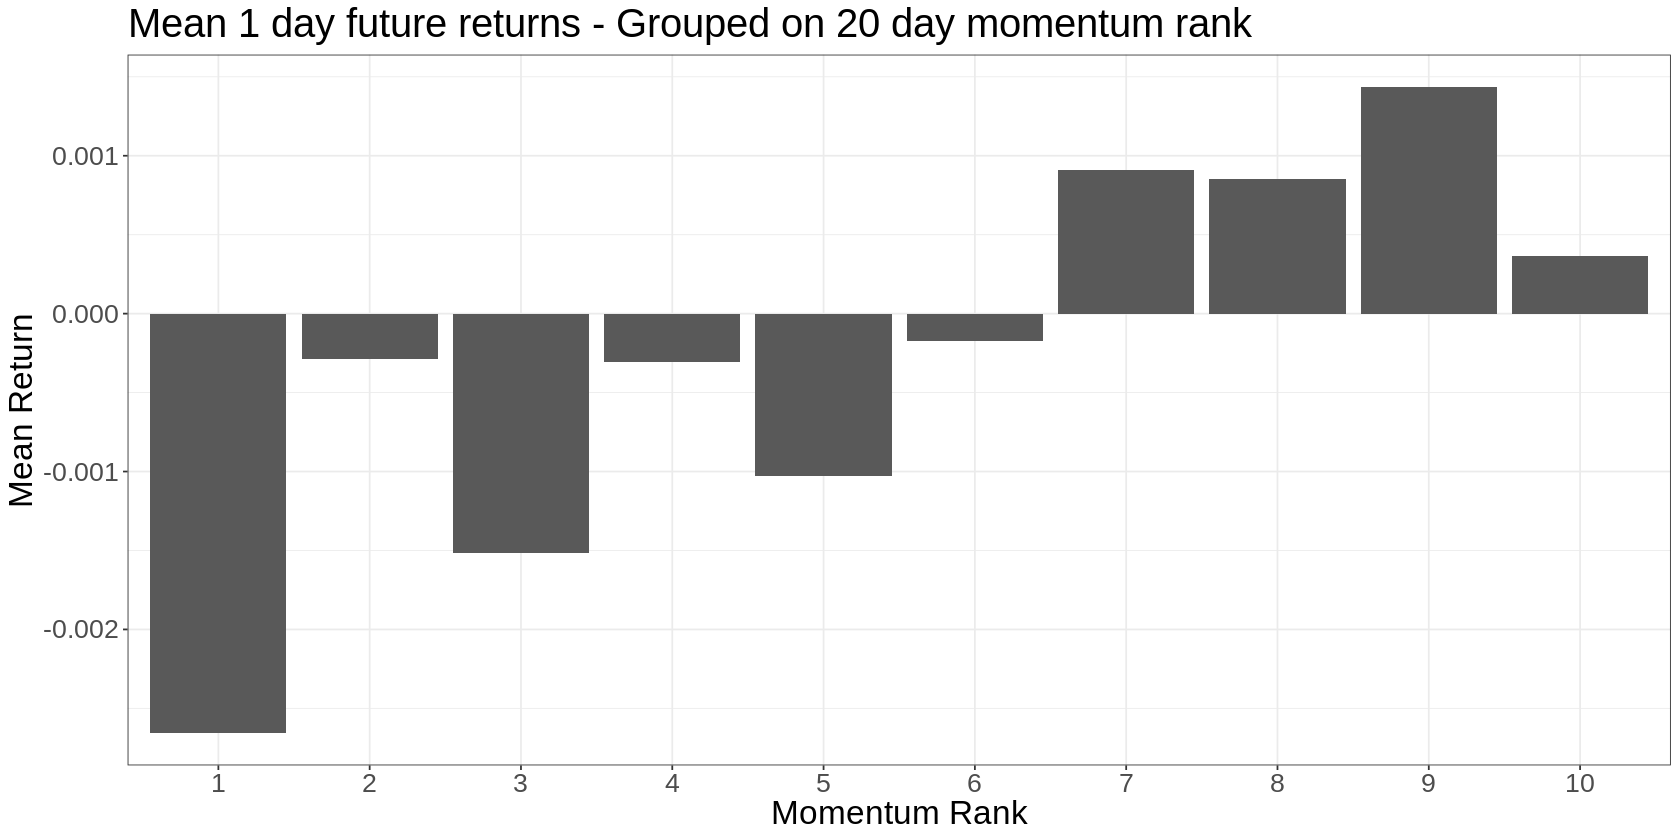

In [ ]:
returns %>%
  filter(is_index == TRUE) %>%
  group_by(Date) %>%
  mutate(rank = factor(row_number(momo20))) %>%
  group_by(rank) %>%
  summarise(mean_fwd_log_ret = mean(fwd_log_return)) %>%
  ggplot(aes(x = rank, y = mean_fwd_log_ret)) +
  geom_bar(stat='identity') +
  labs(
    title = 'Mean 1 day future returns - Grouped on 20 day momentum rank',
    x = 'Momentum Rank',
    y = 'Mean Return'
  )

## Let's look at how this momentum feature varies by snapshot time



In [ ]:
# make hour and date fields outside of for loop
prices <- prices %>%
  mutate(
    Hour = hour(Datetime),
    Date = as_date(Datetime)
  )
# list to store results
momo_returns <- vector(mode = "list", length = 24)

for (i in c(0:23)) {
  # take a daily snapshot at a particular time
  daily_prices <- prices %>%
    filter(Hour == i) %>%
    select(Date, Ticker, Close)

  # create binance universe
  universe_join <- universe %>%
    select(Ticker, Date, MarketCapUSD)

  binance_universe <- daily_prices %>%
    # this will remove any tickers that were removed from the coincodex data
    left_join(universe_join, by = c("Ticker", "Date")) %>%
    na.omit() %>%
    # but we need to create a new universe based on the remaining binance tickers (not all coincodex tickers were trading on binance)
    group_by(Date) %>%
    mutate(cap_rank = row_number(desc(MarketCapUSD))) %>%
    arrange(Date) %>%
    group_by(Ticker) %>%
    mutate(is_index = lag(cap_rank) <= 10 & Date >= start_date) %>%
    na.omit() %>%
    ungroup()

  # calculate momentum feature
  returns <- binance_universe %>%
    group_by(Ticker) %>%
    arrange(Date) %>%
    # Calculate 20d momentum feature
    mutate(momo20 = Close / lag(Close, n = 20) - 1,
          lagmomo20 = lag(momo20)) %>%
    # Calculate next day returns
    mutate(
      fwd_log_return = log(lead(Close) / Close),
      fwd_simple_return = lead(Close) / Close - 1
    ) %>%
    na.omit() %>%
    ungroup()

  # momentum returns
  momo_returns[[i + 1]] <- returns %>%
    filter(is_index == TRUE) %>%
    group_by(Date) %>%
    mutate(rank = factor(row_number(momo20))) %>%
    group_by(rank) %>%
    summarise(mean_fwd_log_ret = mean(fwd_log_return)) %>%
    mutate(snapshot_hour = i)
}

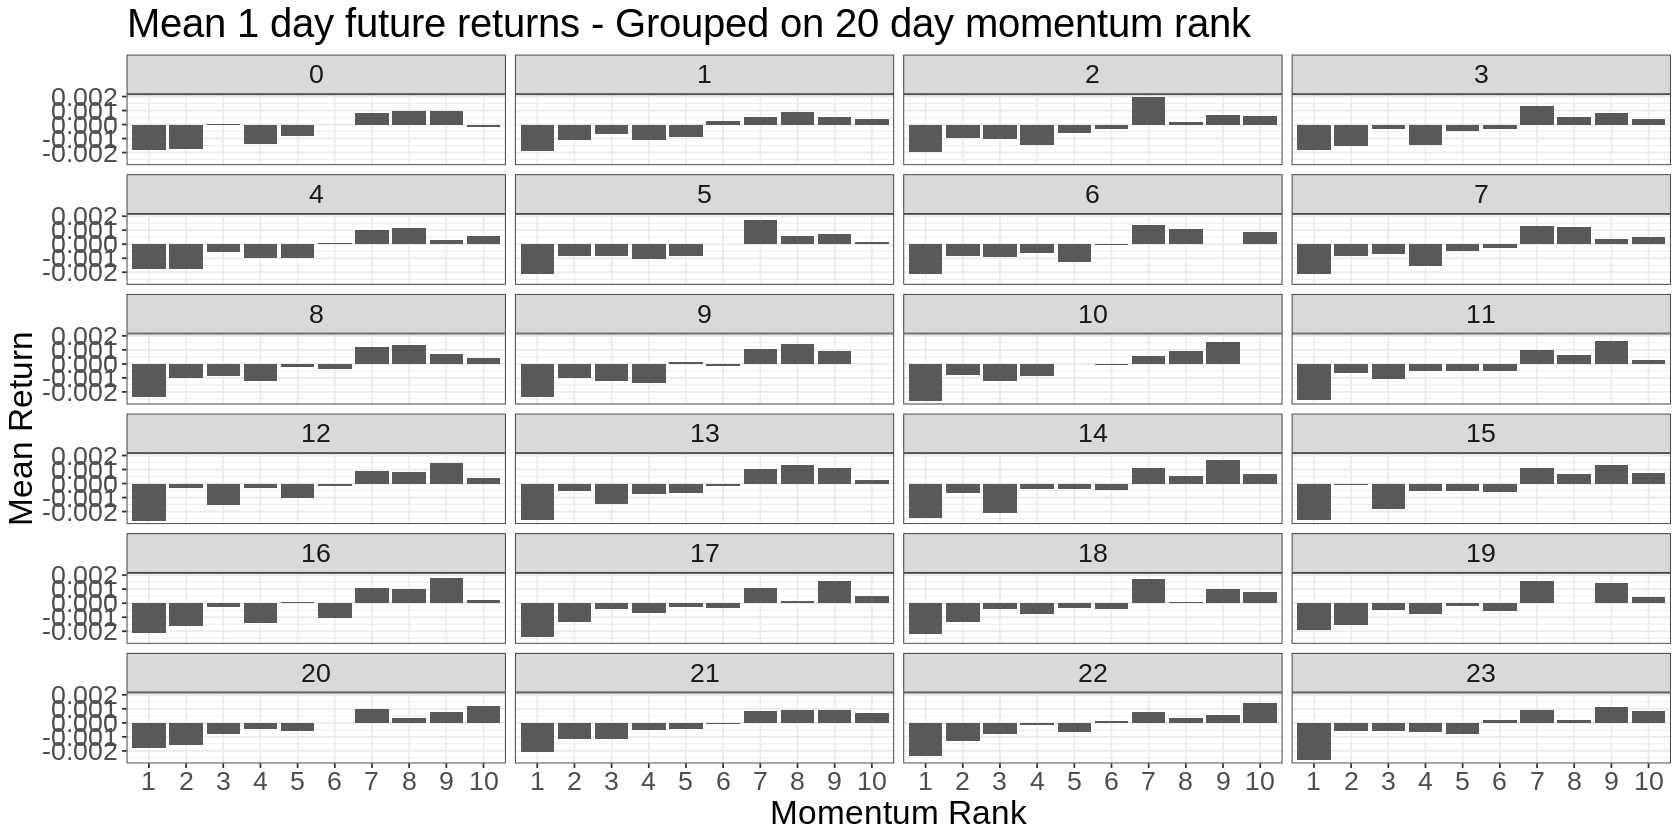

In [ ]:
momo_returns %>%
  bind_rows() %>%
  ggplot(aes(x = rank, y = mean_fwd_log_ret)) +
  geom_bar(stat='identity') +
  facet_wrap(~snapshot_hour, nrow = 6, ncol = 4) +
  labs(
    title = 'Mean 1 day future returns - Grouped on 20 day momentum rank',
    susbtitle = "Daily data snapshotted at different hours",
    x = 'Momentum Rank',
    y = 'Mean Return'
  )

Pretty clear momentum effect regardless of the hour we choose to snapshot the data.  

One major difference in the two data sets is that Coincodex contains a broader universe, including a bunch of stuff that wasn't trading on binance at the time.  

Let's see what happens if we constrain our coincodex universe to what was available to trade on binance.  

In [ ]:
cc_universe <- cc_prices %>%
  filter(Ticker %in% binance_universe$Ticker) %>%
  filter(Date >= start_date) %>%
  create_universe(n=10, min_constituents=10, stables = c(), duplicates = c())  # duplicates and stables already removed

head(cc_universe)

Ticker,Date,Price,Volume,MarketCapUSD,cap_rank,is_index
<chr>,<date>,<dbl>,<dbl>,<dbl>,<int>,<lgl>
ADA,2018-05-28,0.18462359,67007317.891,4769897297.6,7,FALSE
AGIX,2018-05-28,0.13440261,969460.635,78223856.4,52,FALSE
ANT,2018-05-28,2.79055571,305056.192,-1.0,64,FALSE
ARDR,2018-05-28,0.25514723,3008884.085,-1.0,65,FALSE
ATOM,2018-05-28,0.02838197,1163.097,304137.7,62,FALSE
BAT,2018-05-28,0.26419601,1577244.637,-1.0,66,FALSE


In [ ]:
cc_returns <- cc_universe %>%
  group_by(Ticker) %>%
  arrange(Date) %>%
  # Calculate 20d momentum feature
  mutate(
    momo20 = Price / lag(Price, n = 20) - 1,
    lagmomo20 = lag(momo20)
  ) %>%
  # Calculate next day returns
  mutate(fwd_log_return = log(lead(Price) / Price),
         fwd_simple_return = lead(Price) / Price - 1) %>%
  na.omit() %>%
  ungroup()

  returns %>% head(5)

Date,Ticker,Close,MarketCapUSD,cap_rank,is_index,momo20,lagmomo20,fwd_log_return,fwd_simple_return
<date>,<chr>,<dbl>,<dbl>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
2017-09-07,BTC,4691.61,75581470763,1,FALSE,0.14196384,0.07810589,-0.091168806,-0.087136399
2017-09-07,ETH,334.49,30818770935,2,FALSE,0.13787590,0.10927152,-0.098907182,-0.094173219
2017-09-08,BTC,4282.80,73748559954,1,FALSE,0.03449775,0.14196384,-0.005617223,-0.005601476
2017-09-08,ETH,302.99,29641283189,2,FALSE,0.04152487,0.13787590,-0.020843467,-0.020627743
2017-09-09,BTC,4258.81,69792799202,1,FALSE,0.04221923,0.03449775,-0.030622787,-0.030158659


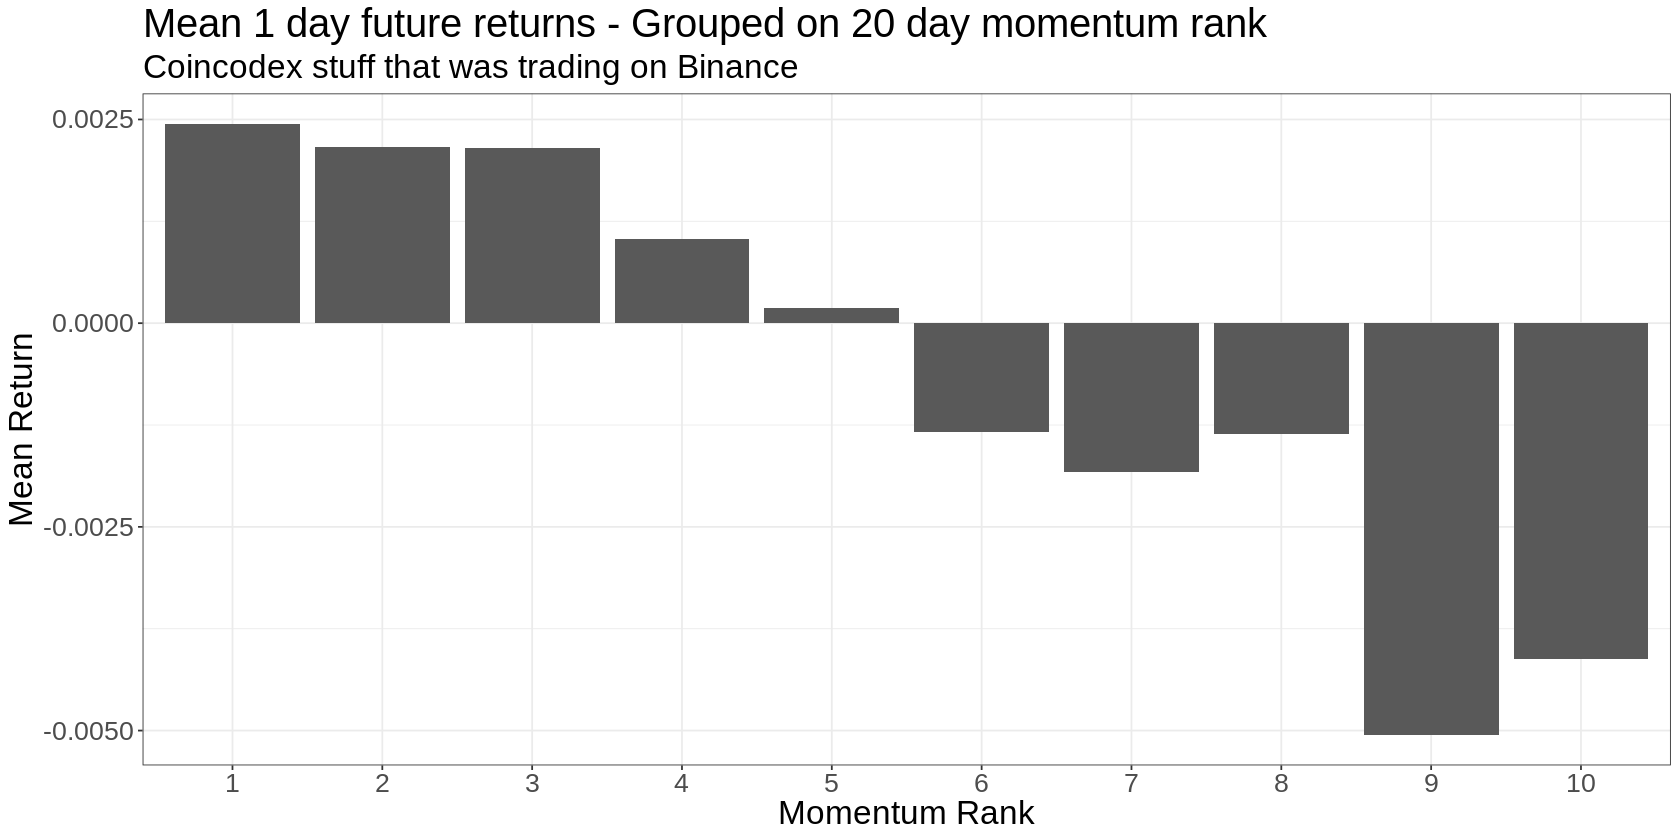

In [ ]:
cc_returns %>%
  filter(is_index == TRUE) %>%
  group_by(Date) %>%
  mutate(rank = factor(row_number(momo20))) %>%
  group_by(rank) %>%
  summarise(mean_fwd_log_ret = mean(fwd_log_return)) %>%
  ggplot(aes(x = rank, y = mean_fwd_log_ret)) +
  geom_bar(stat='identity') +
  labs(
    title = 'Mean 1 day future returns - Grouped on 20 day momentum rank',
    subtitle = "Coincodex stuff that was trading on Binance",
    x = 'Momentum Rank',
    y = 'Mean Return'
  )

The reversal effect persists.  

We also know that Coincodex prices are calculated as a volume weighted average of all prices reported for each market.

That is, it's VWAP across exchanges. This could plausibly result in this day-ahead reversal effect.

Going forward, we'll use Coincodex market cap data to define our universe, but we'll do our analysis on Binance prices and we'll constrain the universe to coins that traded on Binance.

## Function for creating a universe from Binance data

In [ ]:
create_binance_daily_snapshots <- function(prices, snapshot_hour=12) {
  prices %>%
    # retain only the data we need and ditch USDT part of Ticker
    select(Ticker, Datetime, Close) %>%
    mutate(Ticker = str_replace(Ticker, "USDT$", "")) %>%
   # take a daily snapshot at a particular time
    mutate(
      Hour = hour(Datetime),
      Date = as_date(Datetime)
    ) %>%
    filter(Hour == snapshot_hour) %>%
    select(Date, Ticker, Close)
}

#' market_cap: market cap data from coincodex
create_binance_universe <- function(prices, market_cap, n=10, min_constituents=10, stables, to_remove) {
  # Remove stablecoins and others
  prices <- prices %>%
    filter(!Ticker %in% c(stables, to_remove))

  # Get first date where we have min_constituents
  start_date <- prices %>%
    group_by(Date) %>%
    summarise(count = n()) %>%
    filter(count >= min_constituents) %>%
    summarise(mindate = min(Date)) %>%
    pull(mindate)

  start_date <- start_date + 1

  # Flag universe consitutents
  # For a given ticker/date observation, set is_index to TRUE if:
  #    - the asset was in the top 10 coins by market cap the day before
  #    - the date is on or after the date when we have min_consituents assets in our dataset
  binance_universe <- prices %>%
    # this will remove any tickers that were removed from the prices data
    left_join(market_cap, by = c("Ticker", "Date")) %>%
    na.omit() %>%
    # but we need to create a new universe based on the remaining binance tickers (not all coincodex tickers were trading on binance)
    group_by(Date) %>%
    mutate(cap_rank = row_number(desc(MarketCapUSD))) %>%
    arrange(Date) %>%
    group_by(Ticker) %>%
    mutate(is_index = lag(cap_rank) <= n & Date >= start_date) %>%
    na.omit() %>%
    ungroup()
}

In [ ]:
# get fresh data
prices <- rwRtools::crypto_get_binance_spot_1h()
market_cap <- rwRtools::crypto_get_coincodex()

# create daily snapshots
daily_prices <- prices %>%
  create_binance_daily_snapshots(snapshot_hour = 22)

# list of stablecoins from defi llama
url <- "https://stablecoins.llama.fi/stablecoins?includePrices=true"
response <- httr::GET(url)

stables <- response %>%
  content(as = "text", encoding = "UTF-8") %>%
  jsonlite::fromJSON(flatten = TRUE) %>%
  pluck("peggedAssets") %>%
  pull(symbol)

# duplicates and others to remove
to_remove <- c('BTCD', 'HBTC', 'IBBTC', 'RBTC', 'SBTC3', 'WNXM', 'WBTC', 'BNBBULL', 'BNBBEAR', 'EOSBULL', 'EOSBEAR', 'ETHBULL', 'ETHBEAR', 'XRPBULL', 'XRPBEAR')

# create universe
universe <- create_binance_universe(daily_prices, market_cap, n=10, min_constituents=10, stables=stables, to_remove=to_remove)

head(universe)

Date,Ticker,Close,Price,Volume,MarketCapUSD,cap_rank,is_index
<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<lgl>
2017-08-17,BTC,4336.80,4484.7000,2291049129,72153449099,1,FALSE
2017-08-17,ETH,306.74,311.0280,926224826,28752742413,2,FALSE
2017-08-18,BTC,4113.75,4258.8223,2659080208,70206129858,1,FALSE
2017-08-18,ETH,293.74,301.7337,927705861,28406320026,2,FALSE
2017-08-19,BTC,4139.98,3970.5500,3055205366,67500579074,1,FALSE
2017-08-19,ETH,290.91,286.1830,887060788,27839631816,2,FALSE


In [ ]:
# duplicates in binance data
universe %>%
  distinct(Ticker) %>%
  mutate(first3 = str_sub(Ticker, 1,3)) %>%
  group_by(first3) %>%
  reframe(tickercount = n(), Ticker = Ticker) %>%
  filter(tickercount > 1) %>%
  arrange(desc(tickercount))

first3,tickercount,Ticker
<chr>,<int>,<chr>
BCH,2,BCHSV
BCH,2,BCH
CEL,2,CELR
CEL,2,CELO
FLO,2,FLOW
FLO,2,FLOKI
GAL,2,GALA
GAL,2,GAL
GLM,2,GLMR


This looks OK... these tickers are legitimately different.

# Create Momentum Feature and Forward Returns

Calculate 20 day momentum factor and next day returns.

In [ ]:
returns <- universe %>%
  group_by(Ticker) %>%
  arrange(Date) %>%
  # Calculate 20d momentum feature
  mutate(
    momo20 = Close / lag(Close, n = 20) - 1,
    lagmomo20 = lag(momo20)
  ) %>%
  # Calculate next day returns
  mutate(
    fwd_log_return = log(lead(Close) / Close),
    fwd_simple_return = lead(Close) / Close - 1
  ) %>%
  na.omit() %>%
  ungroup()

  head(returns, 10)

Date,Ticker,Close,Price,Volume,MarketCapUSD,cap_rank,is_index,momo20,lagmomo20,fwd_log_return,fwd_simple_return
<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
2017-09-08,BTC,4285.99,4661.0000,1993160104,73748559954,1,FALSE,0.041869341,0.076934606,-0.0030283864,-0.0030238055
2017-09-08,ETH,302.11,285.1570,754892458,29641283189,2,FALSE,0.028494587,0.098650323,-0.0136977030,-0.0136043163
2017-09-09,BTC,4273.03,4215.1859,2366424669,69792799202,1,FALSE,0.032137836,0.041869341,-0.0078212309,-0.0077907246
2017-09-09,ETH,298.00,293.3431,946916233,27692911486,2,FALSE,0.024371799,0.028494587,0.0045867801,0.0045973154
2017-09-10,BTC,4239.74,3951.0400,1517856376,68039152047,1,FALSE,0.016729097,0.032137836,-0.0067851744,-0.0067622071
2017-09-10,ETH,299.37,268.9730,600371355,26922473821,2,FALSE,0.003957208,0.024371799,-0.0092284083,-0.0091859572
2017-09-11,BTC,4211.07,4166.8644,1617781631,68983366189,1,FALSE,0.042060330,0.016729097,-0.0077596553,-0.0077296269
2017-09-11,ETH,296.62,292.8895,653834948,27786953972,2,FALSE,-0.068550793,0.003957208,-0.0003709136,-0.0003708449
2017-09-12,BTC,4178.52,4344.6500,1638364301,70065404526,1,FALSE,0.044107946,0.042060330,-0.0575056277,-0.0558834228


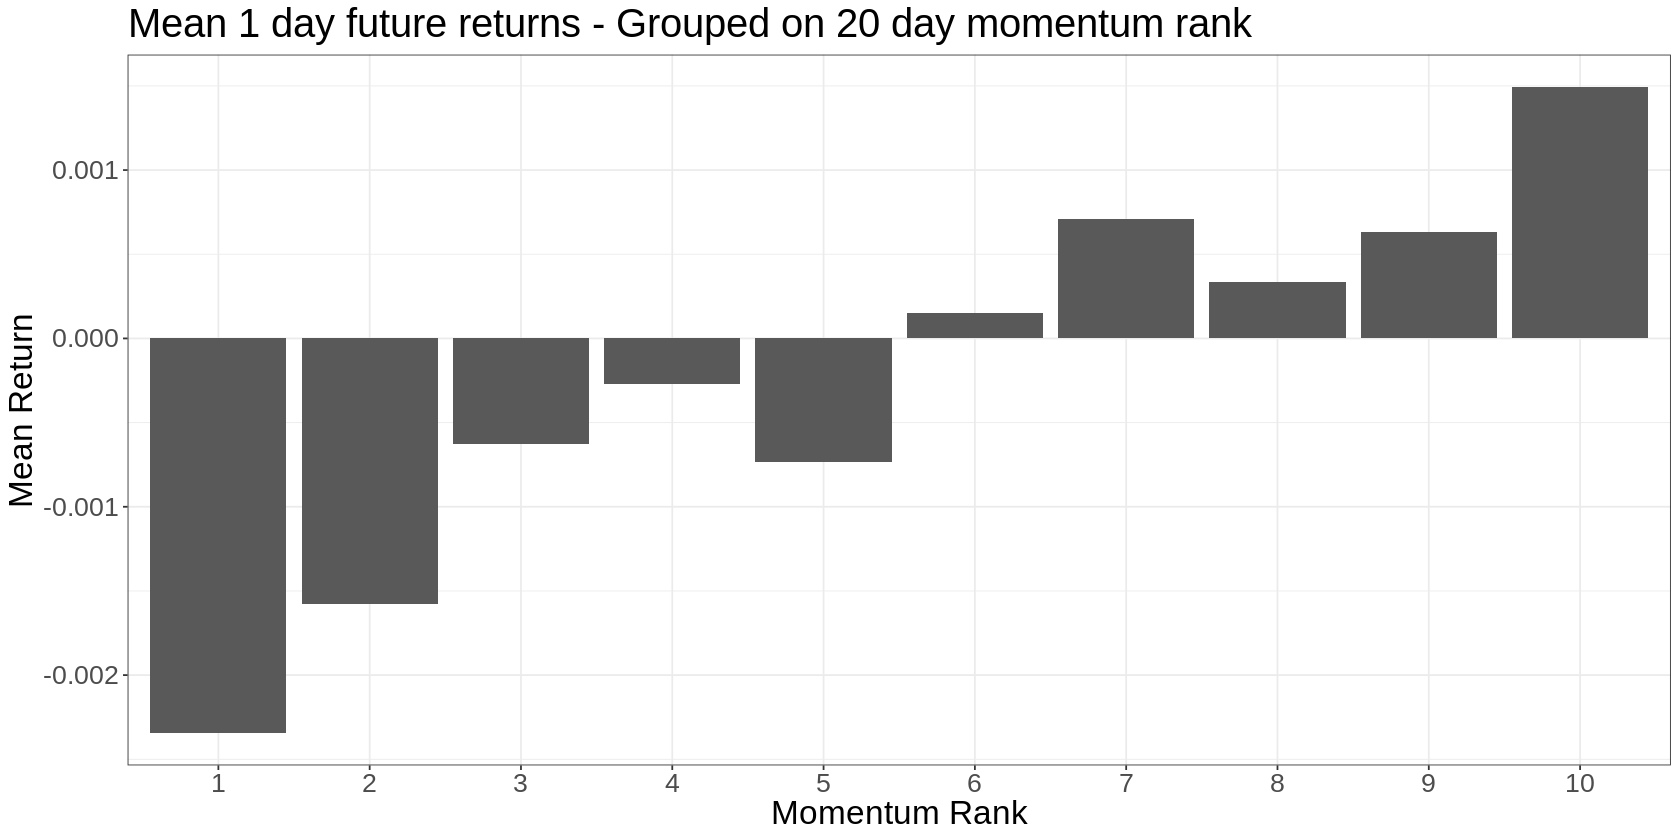

In [ ]:
# plot momentum feature factor plot
returns %>%
  filter(is_index == TRUE) %>%
  group_by(Date) %>%
  mutate(rank = factor(row_number(momo20))) %>%
  group_by(rank) %>%
  summarise(mean_fwd_log_ret = mean(fwd_log_return)) %>%
  ggplot(aes(x = rank, y = mean_fwd_log_ret)) +
  geom_bar(stat='identity') +
  labs(
    title = 'Mean 1 day future returns - Grouped on 20 day momentum rank',
    x = 'Momentum Rank',
    y = 'Mean Return'
  )

Looks good! Matches what we did earlier.

Let's plot this separately for each year in our sample.

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


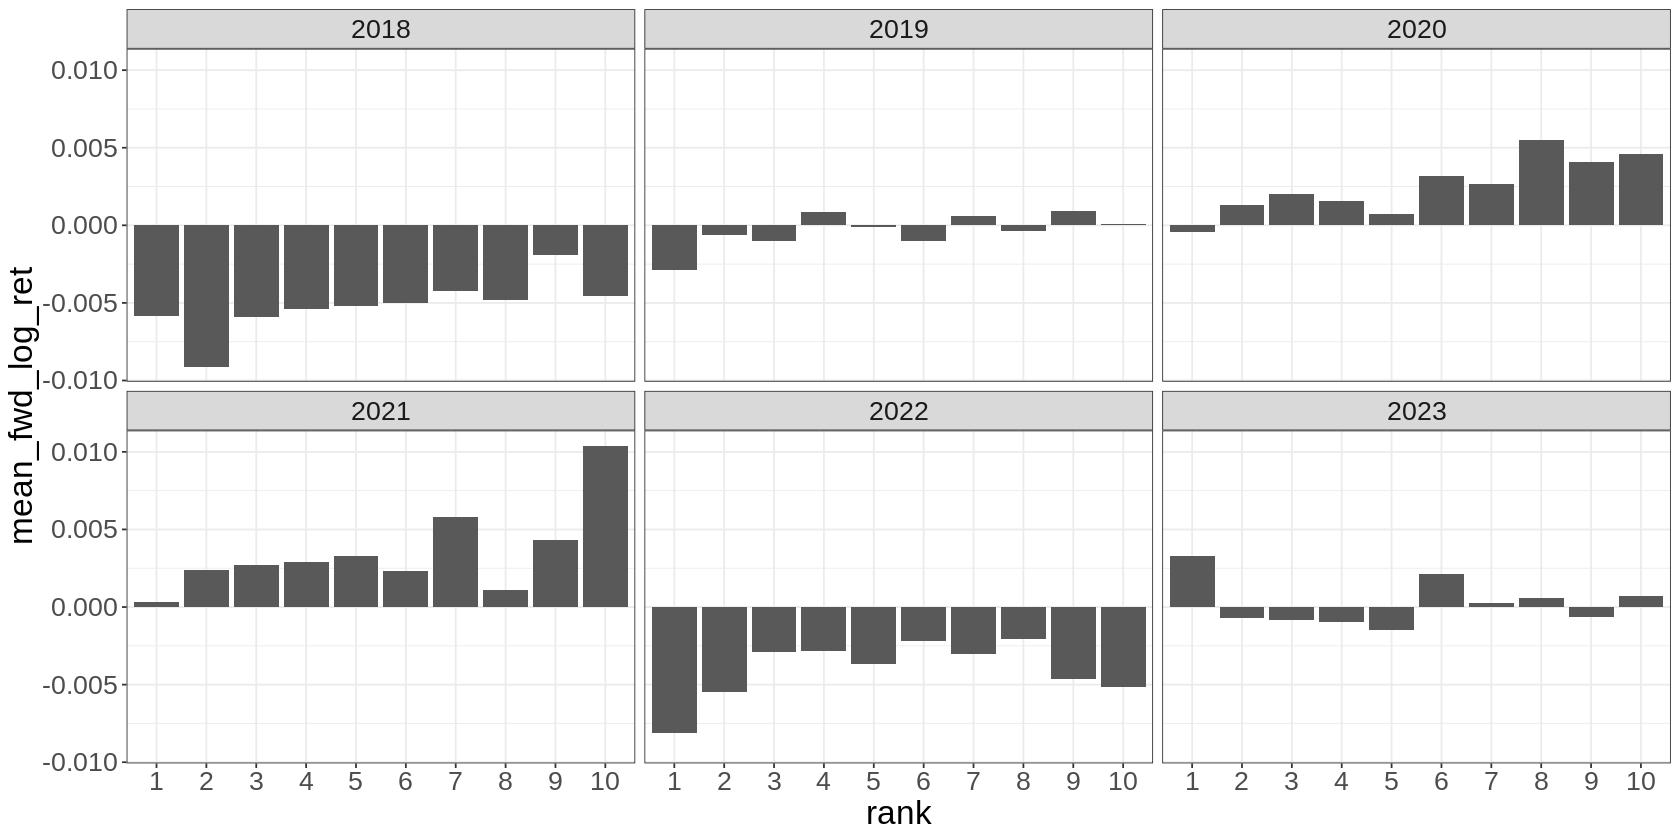

In [ ]:
returns %>%
  mutate(year = factor(year(Date))) %>%
  filter(is_index == TRUE) %>%
  group_by(Date) %>%
  mutate(rank = factor(row_number(momo20))) %>%
  group_by(year, rank) %>%
  summarise(mean_fwd_log_ret = mean(fwd_log_return)) %>%
  ggplot(aes(x=rank, y = mean_fwd_log_ret))  +
  geom_bar(stat='identity') +
  facet_wrap(~year)

Seems to have done alright except for 2023 (so far). To make this easier to interpret, let's demean our return target - so we're plotting the relative outperformance rather than absolute outperformance.

In [ ]:
demeaned_returns <- returns %>%
  filter(is_index) %>%
  group_by(Date) %>%
  mutate(
    demeaned_fwd_log_return = fwd_log_return - mean(fwd_log_return),
    demeaned_fwd_simple_return = fwd_simple_return - mean(fwd_simple_return)
  )

tail(demeaned_returns, 10)

Date,Ticker,Close,Price,Volume,MarketCapUSD,cap_rank,is_index,momo20,lagmomo20,fwd_log_return,fwd_simple_return,demeaned_fwd_log_return,demeaned_fwd_simple_return
<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2023-09-02,ADA,2.556000e-01,2.559081e-01,330169884,8654878824,6,TRUE,-0.1152648,-0.12799452,-0.0015661710,-0.0015649452,0.001549130,0.001508324
2023-09-02,BNB,2.143000e+02,2.144999e+02,708498708,33000853186,3,TRUE,-0.1081981,-0.11351351,-0.0009337069,-0.0009332711,0.002181594,0.002139998
2023-09-02,BTC,2.586151e+04,2.582433e+04,35643936181,502905381049,1,TRUE,-0.1179389,-0.12445245,0.0034389678,0.0034448878,0.006554269,0.006518157
2023-09-02,DOGE,6.352000e-02,6.440820e-02,1962933626,8942534343,5,TRUE,-0.1495515,-0.17305942,-0.0077440134,-0.0077141058,-0.004628712,-0.004640837
2023-09-02,ETH,1.636820e+03,1.638111e+03,7732708399,196926809234,2,TRUE,-0.1100031,-0.12054648,-0.0006355803,-0.0006353784,0.002479721,0.002437891
2023-09-02,LTC,6.450000e+01,6.397434e+01,906103023,4709050107,9,TRUE,-0.2114914,-0.24434876,-0.0105986030,-0.0105426357,-0.007483302,-0.007469367
2023-09-02,SHIB,7.840000e-06,7.894894e-06,81186755,4652831271,10,TRUE,-0.2328767,-0.27247451,-0.0232268506,-0.0229591837,-0.020111550,-0.019885915
2023-09-02,SOL,1.950000e+01,1.949143e+01,3698930628,7964504774,7,TRUE,-0.1972005,-0.22929172,0.0005126891,0.0005128205,0.003627990,0.003586090
2023-09-02,TRX,7.713000e-02,7.691427e-02,4585806584,7102665468,8,TRUE,0.0014282,-0.01754839,-0.0011675425,-0.0011668611,0.001947759,0.001906408


If we've done this right, then the sum of the demeaned returns for all dates should be zero.

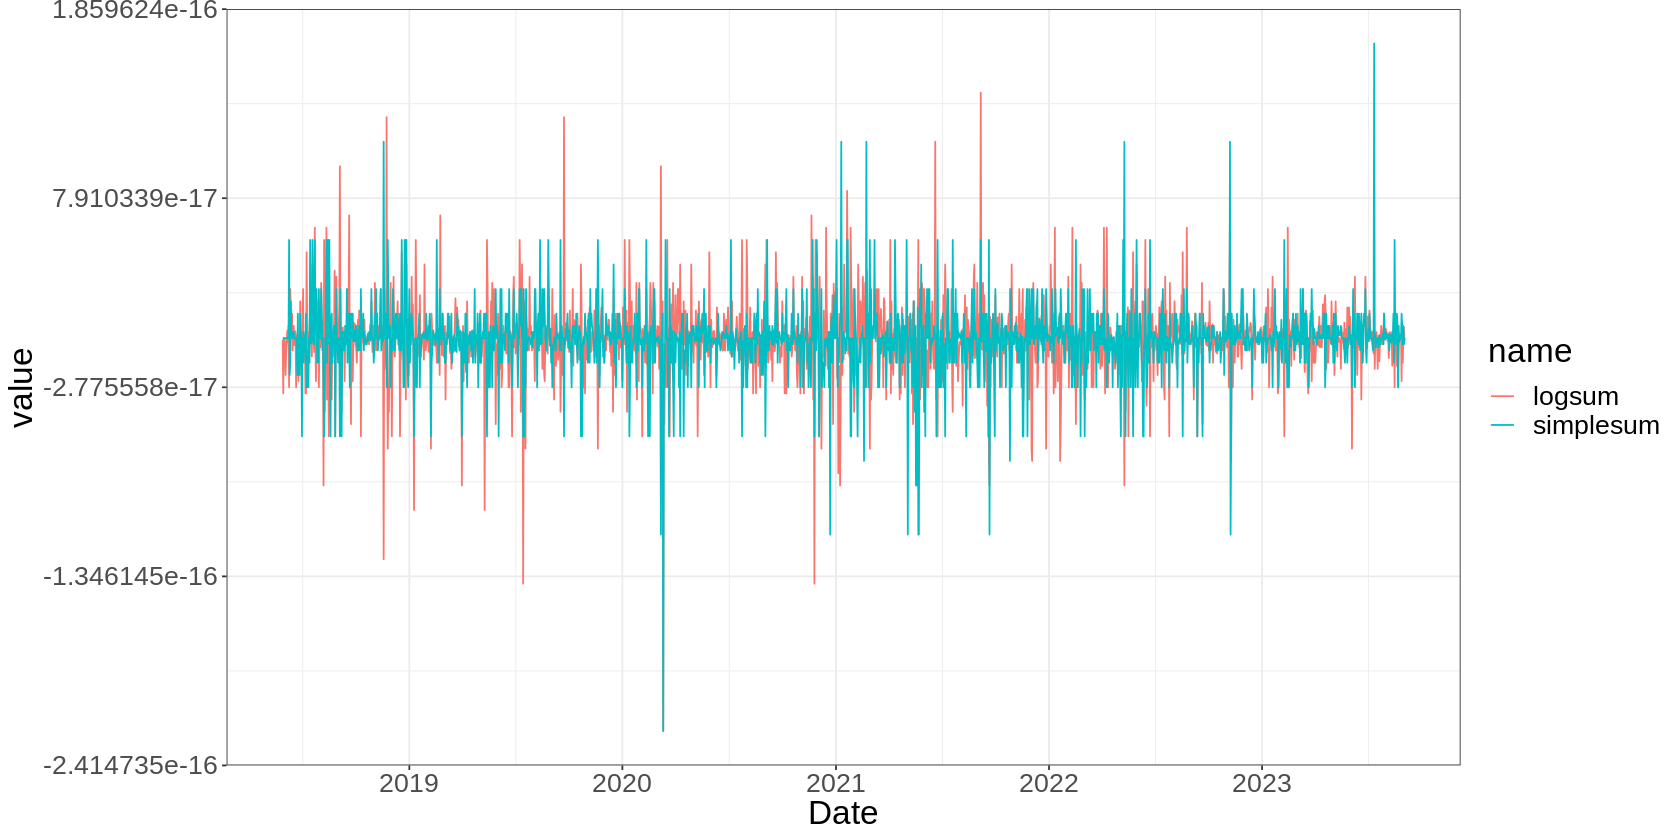

In [ ]:
demeaned_returns %>%
  group_by(Date) %>%
  summarise(
    logsum = sum(demeaned_fwd_log_return),
    simplesum = sum(demeaned_fwd_simple_return)
  ) %>%
  pivot_longer(-Date) %>%
  ggplot(aes(x=Date, y=value, color = name)) +
  geom_line()

Just rounding stuff...

Now let's plot de-meaned log return for each rank for each year

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


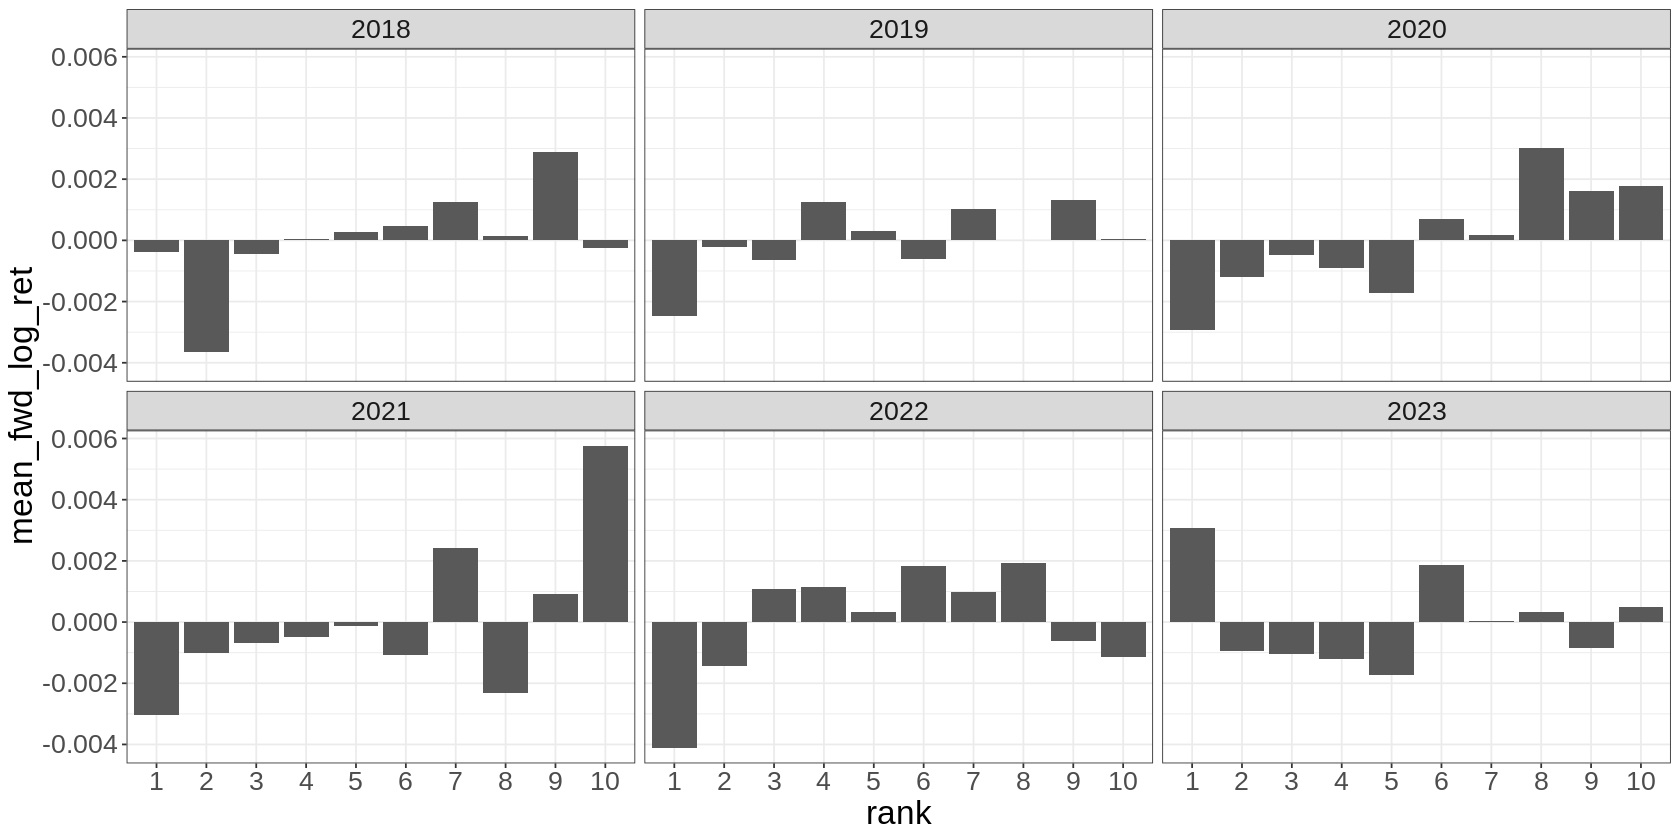

In [ ]:
demeaned_returns %>%
  mutate(year = factor(year(Date))) %>%
  filter(is_index == TRUE) %>%
  group_by(Date) %>%
  mutate(rank = factor(row_number(momo20))) %>%
  group_by(year, rank) %>%
  summarise(mean_fwd_log_ret = mean(demeaned_fwd_log_return)) %>%
  ggplot(aes(x=rank, y = mean_fwd_log_ret))  +
    geom_bar(stat='identity') +
    facet_wrap(~year)

Daily momentum / reversal effects are a thing. I want to put a day in between our feature and target and see if it impacts anything.

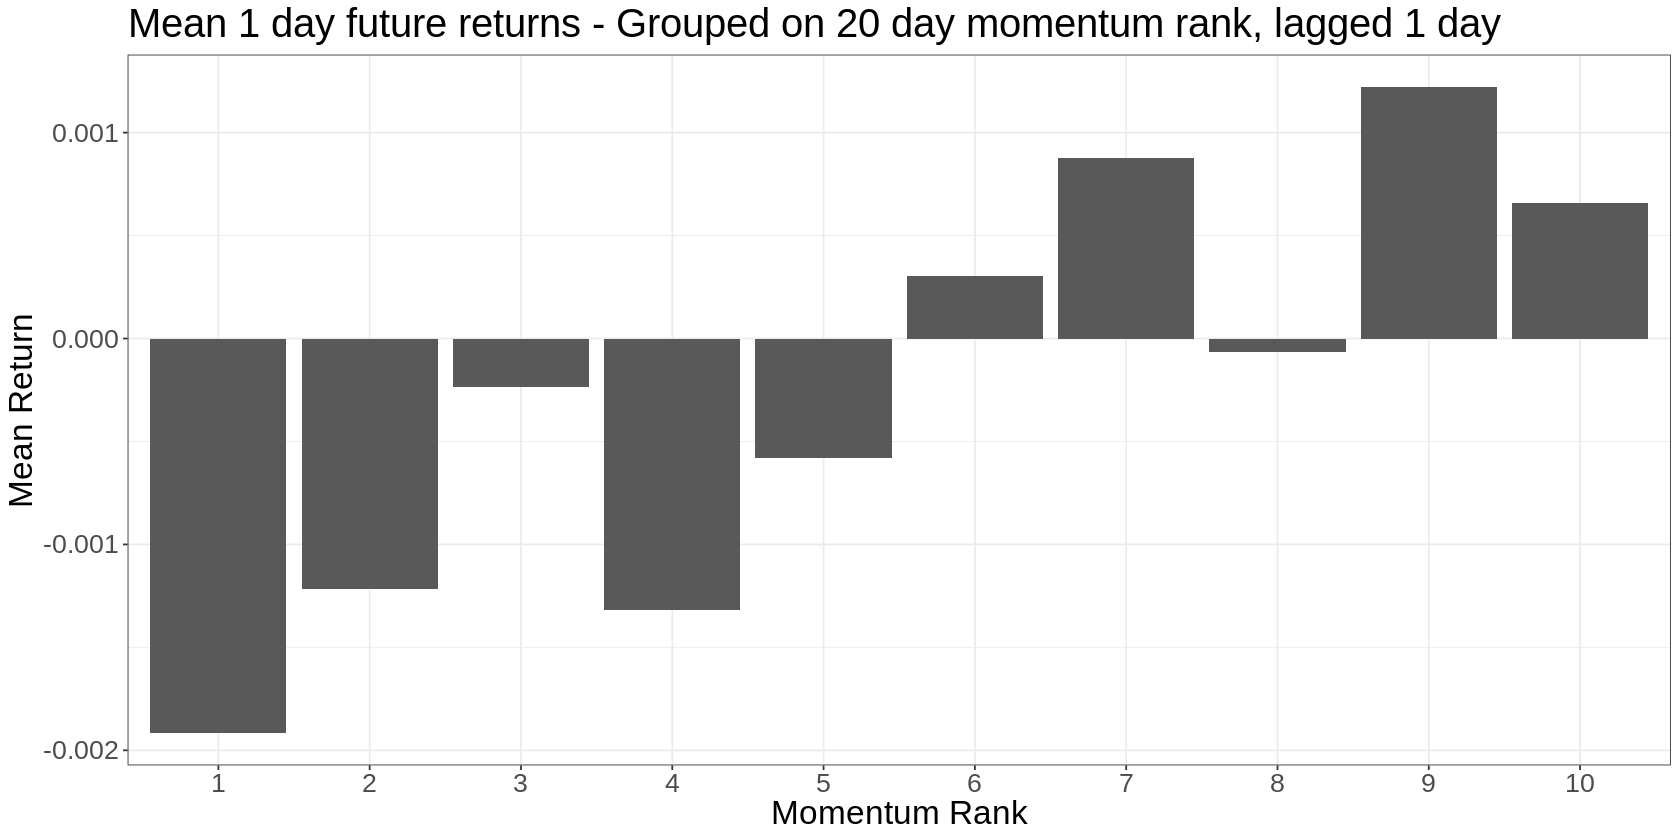

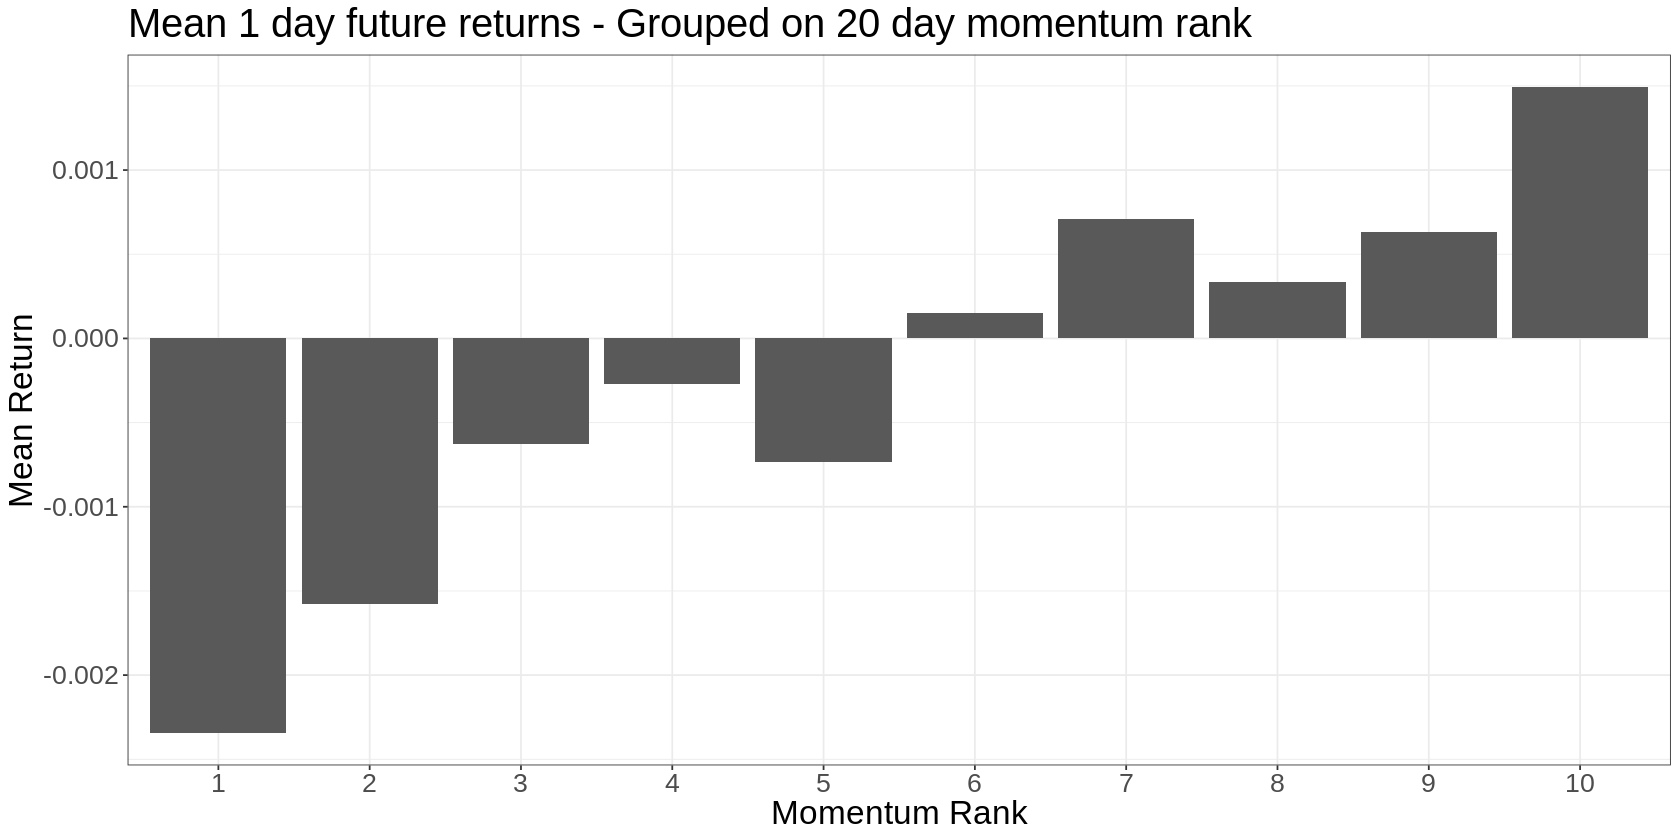

In [ ]:
returns %>%
  filter(is_index == TRUE) %>%
  group_by(Date) %>%
  mutate(lagrank = factor(row_number(lagmomo20))) %>%
  group_by(lagrank) %>%
  summarise(mean_fwd_log_ret = mean(fwd_log_return)) %>%
  ggplot(aes(x=lagrank, y=mean_fwd_log_ret)) +
  geom_bar(stat='identity') +
  labs(
    title = 'Mean 1 day future returns - Grouped on 20 day momentum rank, lagged 1 day',
    x = 'Momentum Rank',
    y = 'Mean Return'
  )

  returns %>%
    filter(is_index == TRUE) %>%
    group_by(Date) %>%
    mutate(rank = factor(row_number(momo20))) %>%
    group_by(rank) %>%
    summarise(mean_fwd_log_ret = mean(fwd_log_return)) %>%
    ggplot(aes(x=rank, y=mean_fwd_log_ret)) +
    geom_bar(stat='identity') +
    labs(
      title = 'Mean 1 day future returns - Grouped on 20 day momentum rank',
      x = 'Momentum Rank',
      y = 'Mean Return'
    )

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


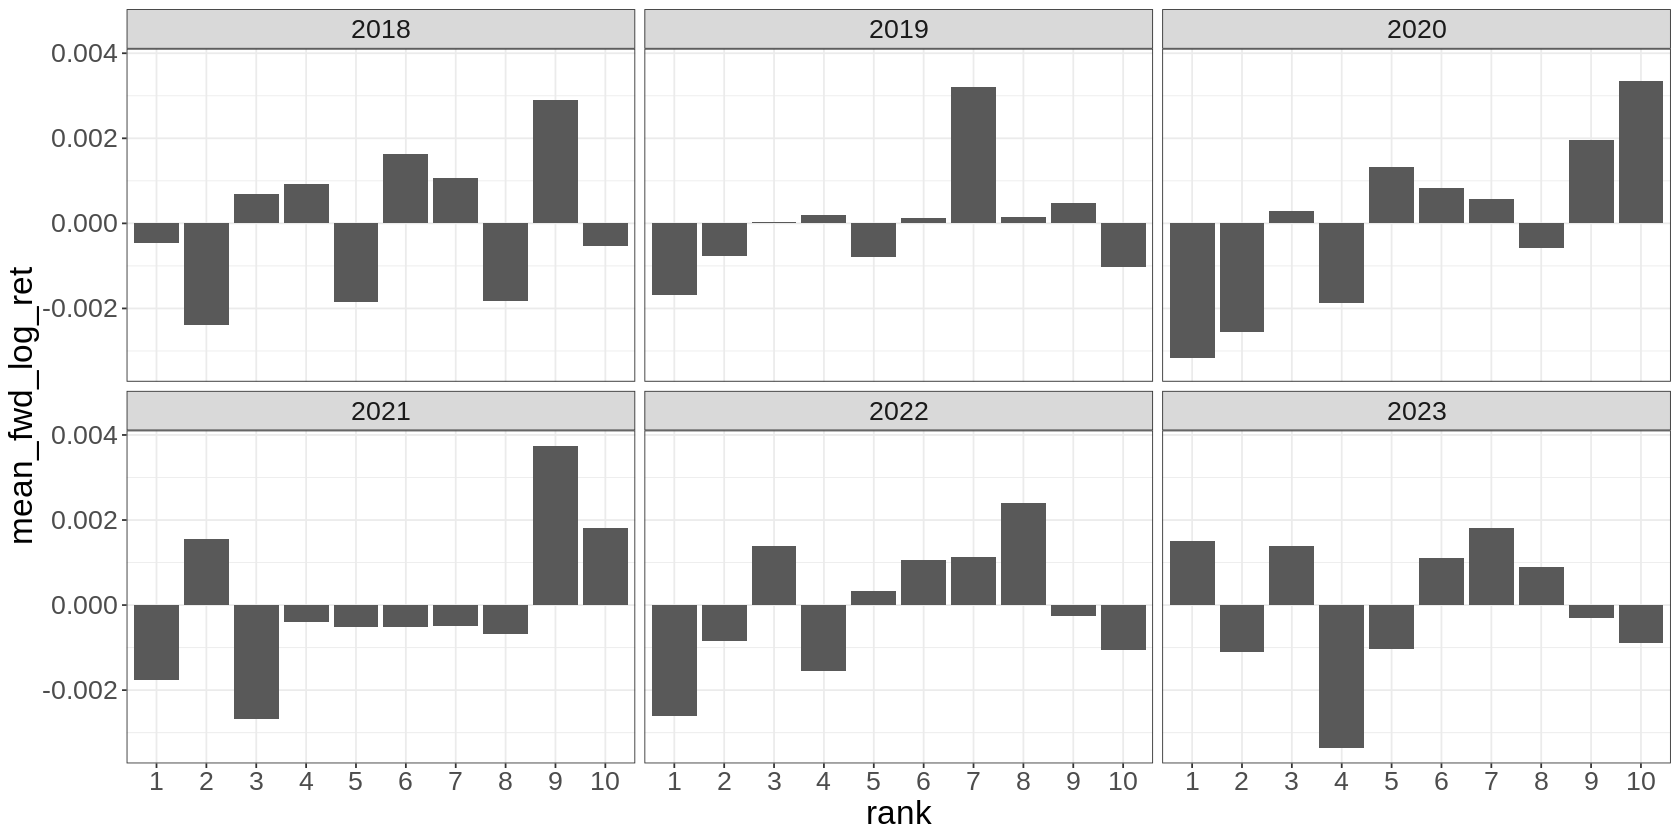

In [ ]:
demeaned_returns %>%
  mutate(year = factor(year(Date))) %>%
  filter(is_index == TRUE) %>%
  group_by(Date) %>%
  mutate(rank = factor(row_number(lagmomo20))) %>%
  group_by(year, rank) %>%
  summarise(mean_fwd_log_ret = mean(demeaned_fwd_log_return)) %>%
  ggplot(aes(x=rank, y = mean_fwd_log_ret))  +
    geom_bar(stat='identity') +
    facet_wrap(~year)

Looks quite robust to adding a day between feature and target. 2023 may be an exception.

# Creating a factor time series

Now, we're going to construct a number of factor time series.

1. Top decile - bottom decile
2. Weight all assets in proportion to rank - mean(rank)
3. Weight all assets in proportion to zscore


## 1: Top - Bottom Decile Factor Plot

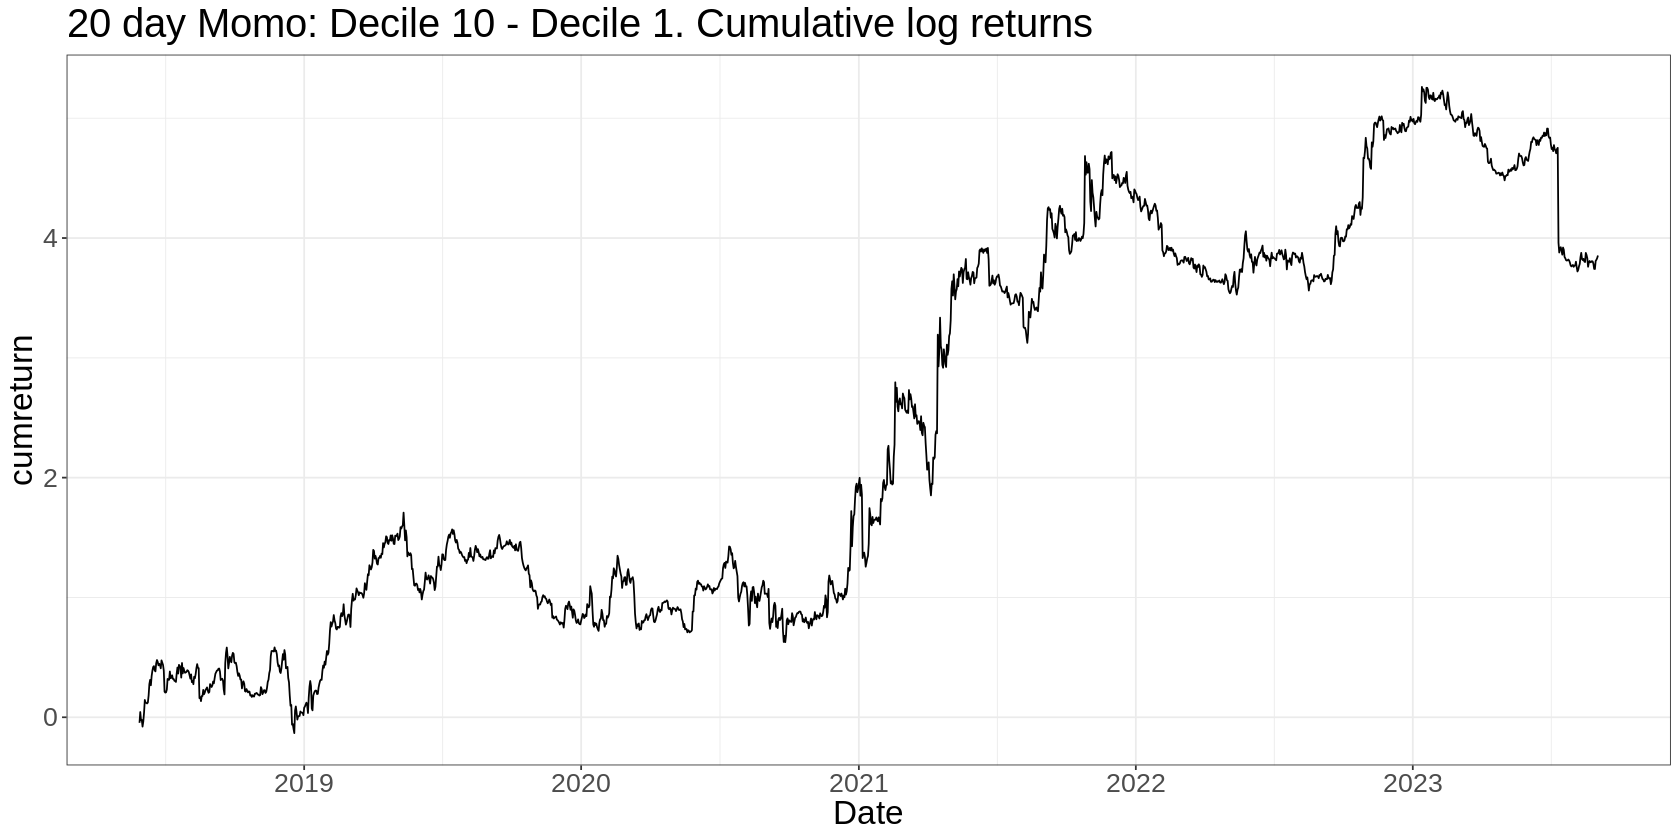

In [ ]:
top_ranked <- returns %>%
  filter(is_index) %>%
  group_by(Date) %>%
  mutate(rank = row_number(momo20)) %>%
  filter(rank == max(rank)) %>%
  select(Date, top_return = fwd_simple_return)

bottom_ranked <- returns %>%
  filter(is_index) %>%
  group_by(Date) %>%
  mutate(rank = row_number(momo20)) %>%
  filter(rank == min(rank)) %>%
  select(Date, bottom_return = fwd_simple_return)

top_ranked %>%
  inner_join(bottom_ranked, by = 'Date') %>%
  mutate(
    factor_return = top_return - bottom_return,
    log_factor_return = log(1+factor_return)
  ) %>%
  ungroup() %>%
  arrange(Date) %>%
  mutate(cumreturn = cumsum(log_factor_return)) %>%
  ggplot(aes(x=Date, y=cumreturn)) +
    geom_line() +
    ggtitle('20 day Momo: Decile 10 - Decile 1. Cumulative log returns')



##2: Weight all assets in proportion to rank - mean(rank)

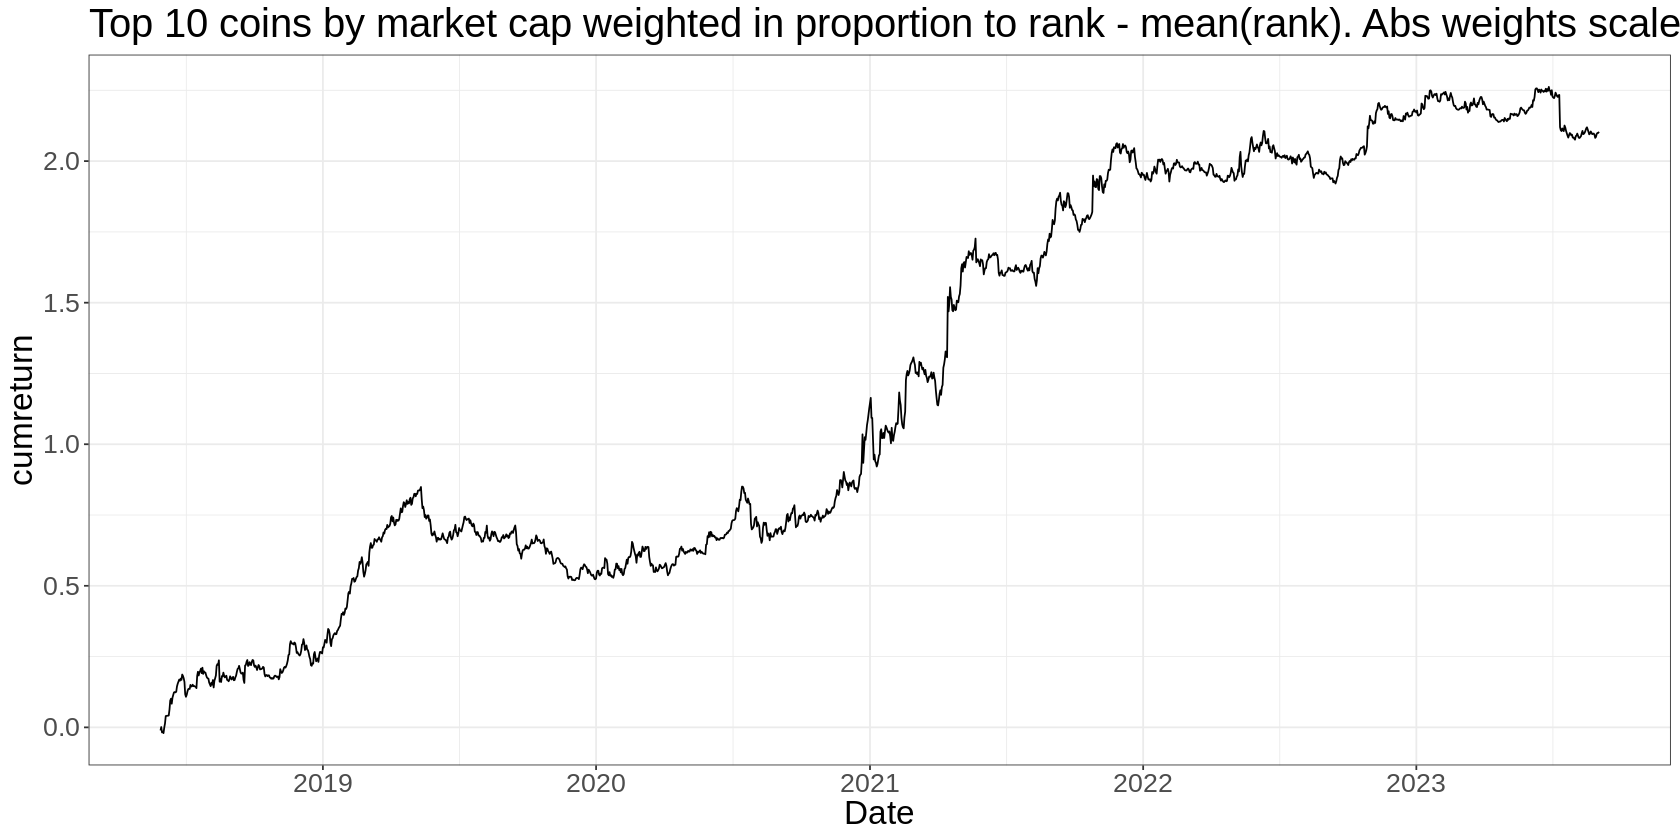

In [ ]:
returns %>%
  filter(is_index) %>%
  group_by(Date) %>%
  mutate(
    rank = row_number(momo20),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = fwd_simple_return * scaled_weight
  ) %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  ungroup() %>%
  arrange(Date) %>%
  mutate(cumreturn = cumsum(log_factor_return)) %>%
  ggplot(aes(x=Date, y=cumreturn)) +
    geom_line() +
    ggtitle('Top 10 coins by market cap weighted in proportion to rank - mean(rank). Abs weights scaled to 1. Cum log returns')

##3: Weight assets in Proprtion to Momentum ZScore

The zscore of an observation is the number of standard deviations above or below the sample mean that an observation sits.

It's a useful way to standardize how different the observations are.

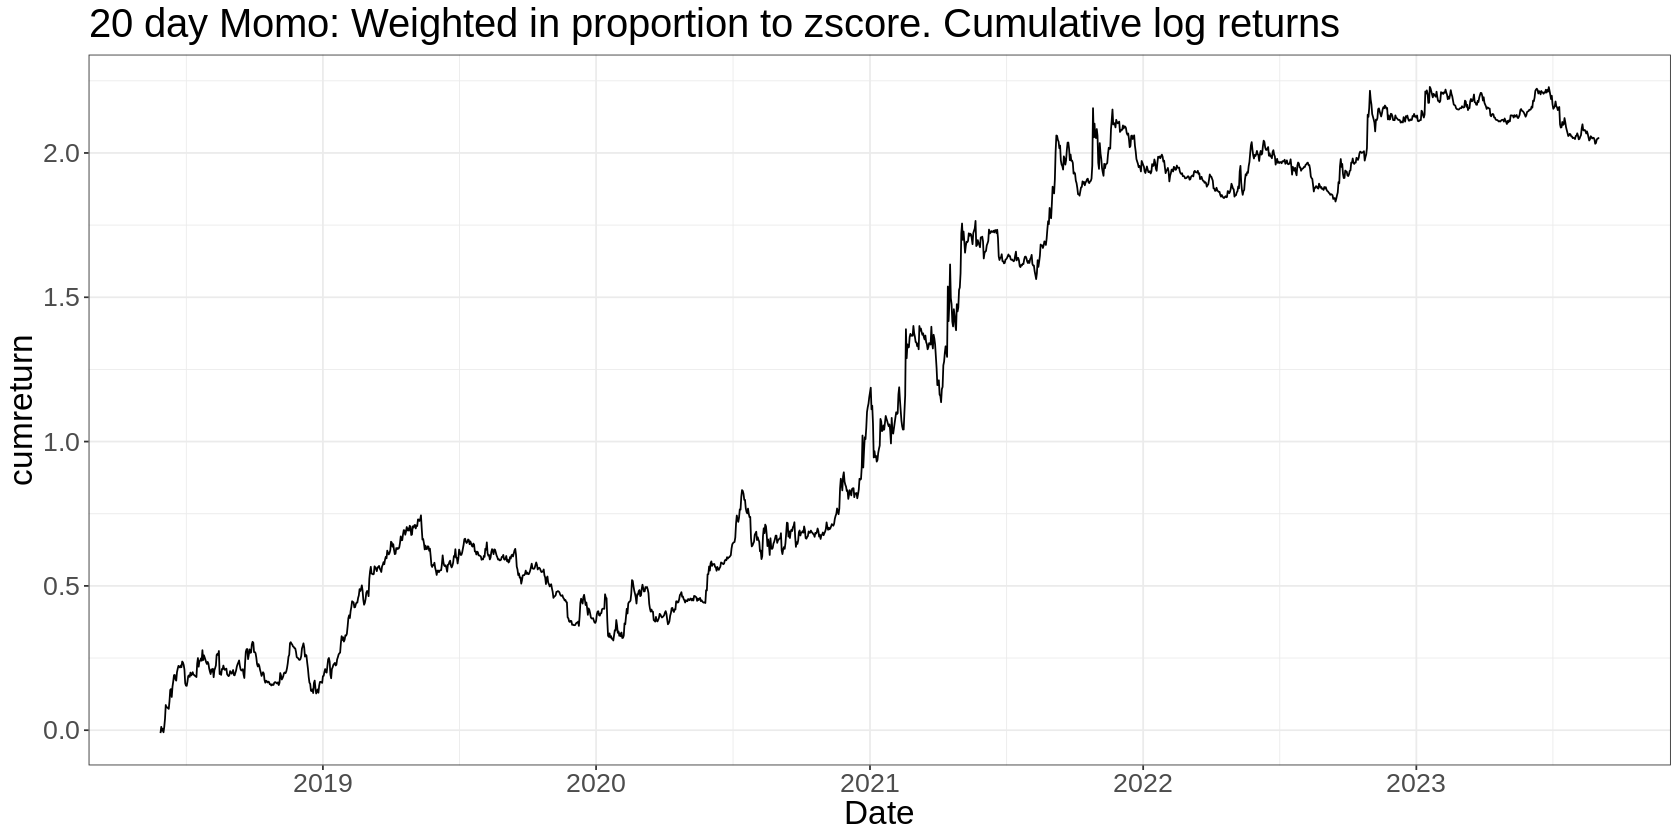

In [ ]:
returns %>%
  filter(is_index) %>%
  group_by(Date) %>%
  mutate(
    zscore = (momo20 - mean(momo20)) / sd(momo20),
    scaled_weight = zscore / sum(abs(zscore)),
    weighted_fwd_returns = fwd_simple_return * scaled_weight
  ) %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  ungroup() %>%
  arrange(Date) %>%
  mutate(cumreturn = cumsum(log_factor_return)) %>%
  ggplot(aes(x=Date, y=cumreturn)) +
    geom_line() +
    ggtitle('20 day Momo: Weighted in proportion to zscore. Cumulative log returns')

What if we max zscore out at 2...



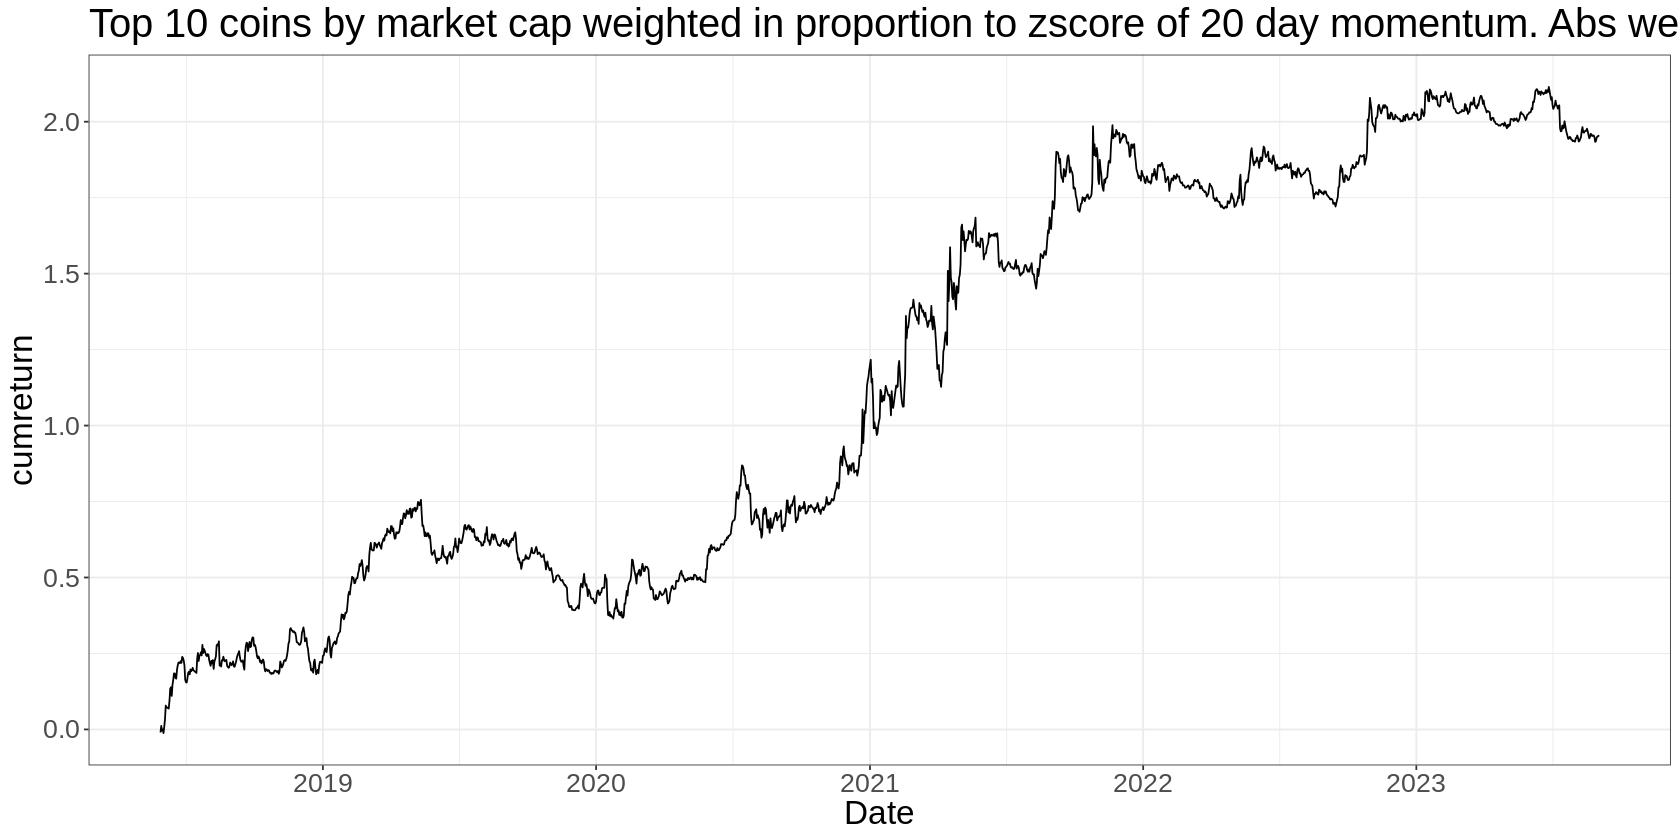

In [ ]:
returns %>%
  filter(is_index) %>%
  group_by(Date) %>%
  mutate(
    zscore = (momo20 - mean(momo20)) / sd(momo20),
    weight = case_when(zscore < -2 ~ -2, zscore > 2 ~ 2, TRUE ~ zscore),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = fwd_simple_return * scaled_weight
  ) %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  ungroup() %>%
  arrange(Date) %>%
  mutate(cumreturn = cumsum(log_factor_return)) %>%
  ggplot(aes(x=Date, y=cumreturn)) +
    geom_line() +
    ggtitle('Top 10 coins by market cap weighted in proportion to zscore of 20 day momentum. Abs weights scaled to 1. Cum log returns')

# Analyzing multiple lookbacks of the momentum factor

Let's do the same thing, but with momentum lookbacks of different length.


In [ ]:
lookback_returns <- universe %>%
  group_by(Ticker) %>%
  arrange(Date) %>%
  # Calculate 20d momentum feature
  mutate(
    # Give columns the name of the lookback for pivoting long to tidy format later
    "3" = Close / lag(Close, n = 3) - 1,
    "5" = Close / lag(Close, n = 5) - 1,
    "7" = Close / lag(Close, n = 7) - 1,
    "10" = Close / lag(Close, n = 10) - 1,
    "15" = Close / lag(Close, n = 15) - 1,
    "20" = Close / lag(Close, n = 20) - 1,
    "30" = Close / lag(Close, n = 30) - 1,
    "40" = Close / lag(Close, n = 40) - 1,
    "50" = Close / lag(Close, n = 50) - 1,
    "60" = Close / lag(Close, n = 60) - 1,
  ) %>%
  # Calculate next day returns
  mutate(fwd_log_return = log(lead(Close) / Close),
         fwd_simple_return = lead(Close) / Close - 1) %>%
  na.omit() %>%
  ungroup() %>%
  # Convert to tidy format
  pivot_longer("3":"60", names_to = "lookback", values_to = "momo") %>%
  mutate(lookback = as.numeric(lookback))

lookback_returns %>% tail(10)

Date,Ticker,Close,Price,Volume,MarketCapUSD,cap_rank,is_index,fwd_log_return,fwd_simple_return,lookback,momo
<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
2023-09-02,ZRX,0.1632,0.1603414,18568741,137090599,118,FALSE,0.006717583,0.006740196,3,-0.05828044
2023-09-02,ZRX,0.1632,0.1603414,18568741,137090599,118,FALSE,0.006717583,0.006740196,5,-0.04728546
2023-09-02,ZRX,0.1632,0.1603414,18568741,137090599,118,FALSE,0.006717583,0.006740196,7,-0.04784131
2023-09-02,ZRX,0.1632,0.1603414,18568741,137090599,118,FALSE,0.006717583,0.006740196,10,-0.07587769
2023-09-02,ZRX,0.1632,0.1603414,18568741,137090599,118,FALSE,0.006717583,0.006740196,15,-0.05936599
2023-09-02,ZRX,0.1632,0.1603414,18568741,137090599,118,FALSE,0.006717583,0.006740196,20,-0.25171939
2023-09-02,ZRX,0.1632,0.1603414,18568741,137090599,118,FALSE,0.006717583,0.006740196,30,-0.25885559
2023-09-02,ZRX,0.1632,0.1603414,18568741,137090599,118,FALSE,0.006717583,0.006740196,40,-0.20930233
2023-09-02,ZRX,0.1632,0.1603414,18568741,137090599,118,FALSE,0.006717583,0.006740196,50,-0.24409449


`summarise()` has grouped output by 'lookback'. You can override using the
`.groups` argument.


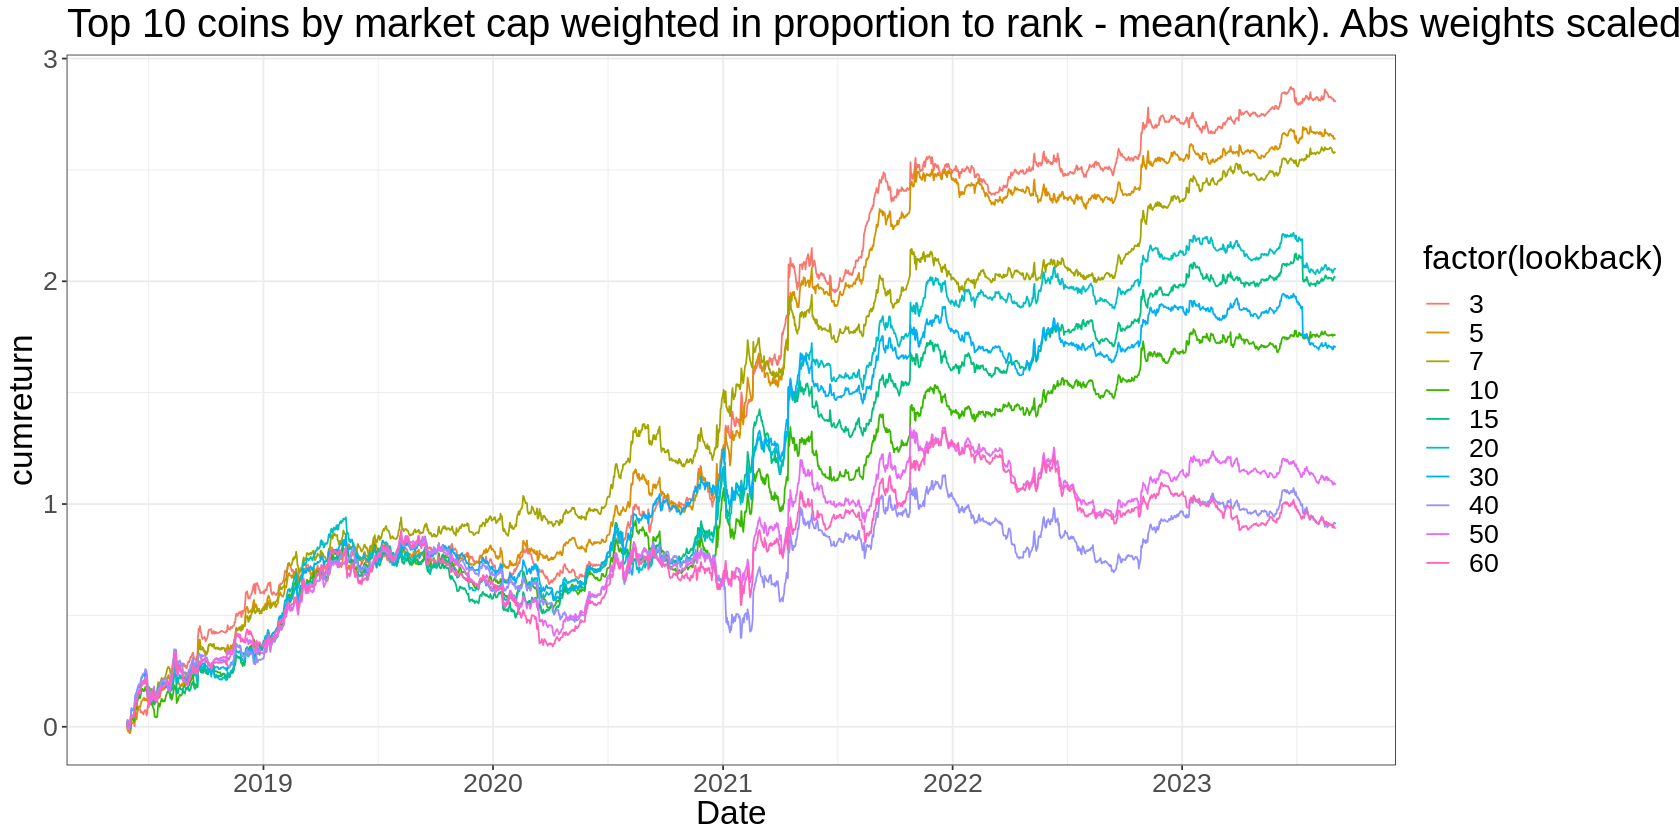

In [ ]:
lookback_returns %>%
  filter(is_index) %>%
  group_by(lookback, Date) %>%
  mutate(
    rank = row_number(momo),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = fwd_simple_return * scaled_weight
  ) %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  group_by(lookback) %>%
  arrange(Date) %>%
  mutate(cumreturn = cumsum(log_factor_return)) %>%
  ggplot(aes(x=Date, y=cumreturn, color = factor(lookback))) +
    geom_line() +
    ggtitle('Top 10 coins by market cap weighted in proportion to rank - mean(rank). Abs weights scaled to 1. Cum log returns')

Let's tabulate summary information.


In [ ]:
lookback_returns %>%
  filter(is_index) %>%
  group_by(lookback, Date) %>%
  mutate(
    rank = row_number(momo),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = fwd_simple_return * scaled_weight
  ) %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  group_by(lookback) %>%
  summarise(
    meanreturn = mean(log_factor_return) * 365,
    volreturn = sd(log_factor_return) * sqrt(365),
    ir = meanreturn / volreturn
  ) %>%
  arrange(desc(meanreturn))

`summarise()` has grouped output by 'lookback'. You can override using the
`.groups` argument.


lookback,meanreturn,volreturn,ir
<dbl>,<dbl>,<dbl>,<dbl>
3,0.5326257,0.3105394,1.7151628
5,0.5012629,0.3071289,1.6320926
7,0.4894086,0.3041953,1.6088632
20,0.3910999,0.3031804,1.2899906
15,0.3833377,0.3023919,1.2676852
10,0.3338659,0.2984001,1.1188532
30,0.3233527,0.2924550,1.1056496
50,0.2062485,0.2884987,0.7149025
40,0.1727097,0.2925006,0.5904593


# Alternative Momentum Factors

There is no "correct" way to define momentum - so we'd expect to see a momentum effect however we chose to measure it.

Here let's look at the difference between current price and a moving average of price.

We follow the same process as before, calculating the factor for a range of lookbacks, constructing factors and tabulating results.

`summarise()` has grouped output by 'lookback'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'lookback'. You can override using the
`.groups` argument.


lookback,meanreturn,volreturn,ir
<dbl>,<dbl>,<dbl>,<dbl>
5,0.6379895,0.3106245,2.053893
7,0.6124745,0.3108406,1.970382
3,0.5909566,0.3087814,1.913835
10,0.5199492,0.3085949,1.684892
20,0.4445896,0.3041666,1.461665
15,0.4438959,0.3054869,1.453077
30,0.4171061,0.3044663,1.369958
40,0.3640846,0.3040150,1.197588
60,0.3143544,0.2991880,1.050692


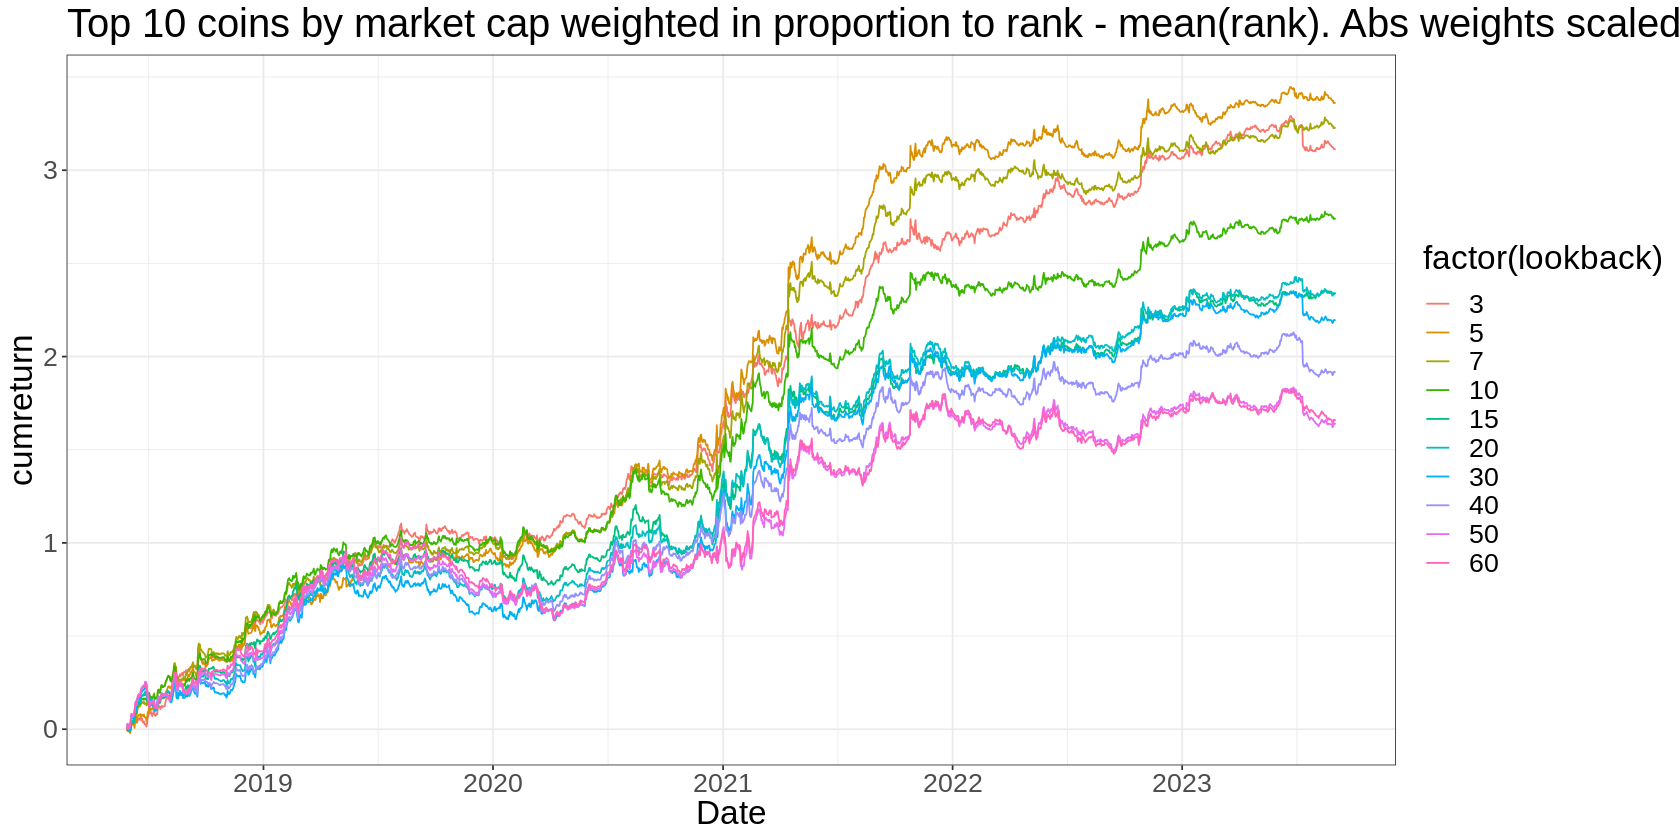

In [ ]:
psma_lookback_returns <- universe %>%
  group_by(Ticker) %>%
  arrange(Date) %>%
  # Calculate price to sma feature
  mutate(
    # Give columns the name of the lookback for pivoting long to tidy format later
    "3" = Close / roll_meanr(Close, 3) - 1,
    "5" = Close / roll_meanr(Close, 5) - 1,
    "7" = Close / roll_meanr(Close, 7) - 1,
    "10" = Close / roll_meanr(Close, 10) - 1,
    "15" = Close / roll_meanr(Close, 15) - 1,
    "20" = Close / roll_meanr(Close, 20) - 1,
    "30" = Close / roll_meanr(Close, 30) - 1,
    "40" = Close / roll_meanr(Close, 40) - 1,
    "50" = Close / roll_meanr(Close, 50) - 1,
    "60" = Close / roll_meanr(Close, 60) - 1,
  ) %>%
  # Calculate next day returns
  mutate(fwd_log_return = log(lead(Close) / Close),
         fwd_simple_return = lead(Close) / Close - 1) %>%
  na.omit() %>%
  ungroup() %>%
  # Convert to tidy format
  pivot_longer("3":"60", names_to = "lookback", values_to = "momo") %>%
  mutate(lookback = as.numeric(lookback))

psma_lookback_returns %>%
  filter(is_index) %>%
  group_by(lookback, Date) %>%
  mutate(
    rank = row_number(momo),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = fwd_simple_return * scaled_weight
  ) %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  group_by(lookback) %>%
  arrange(Date) %>%
  mutate(cumreturn = cumsum(log_factor_return)) %>%
  ggplot(aes(x=Date, y=cumreturn, color = factor(lookback))) +
    geom_line() +
    ggtitle('Top 10 coins by market cap weighted in proportion to rank - mean(rank). Abs weights scaled to 1. Cum log returns')

psma_lookback_returns %>%
  filter(is_index) %>%
  group_by(lookback, Date) %>%
  mutate(
    rank = row_number(momo),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = fwd_simple_return * scaled_weight
  ) %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  group_by(lookback) %>%
  summarise(
    meanreturn = mean(log_factor_return) * 365,
    volreturn = sd(log_factor_return) * sqrt(365),
    ir = meanreturn / volreturn
  ) %>%
  arrange(desc(meanreturn))

This looks similar - if not slightly better than the pure return factor. That may simply because it "effectively" has a shorter lookback.

# 20 Asset Universe

We want these effects to be robust to any reasonable universe. Let's look at 20 asset universe.

`summarise()` has grouped output by 'lookback'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'lookback'. You can override using the
`.groups` argument.


lookback,meanreturn,volreturn,ir
<dbl>,<dbl>,<dbl>,<dbl>
7,0.3966187,0.2489942,1.5928833
20,0.3598717,0.2559629,1.4059528
3,0.3583212,0.2589702,1.3836390
15,0.3292899,0.2569583,1.2814915
5,0.3156237,0.2529678,1.2476831
30,0.2904229,0.2502923,1.1603349
10,0.2603675,0.2552292,1.0201321
40,0.2348978,0.2479822,0.9472364
50,0.2086302,0.2385533,0.8745644


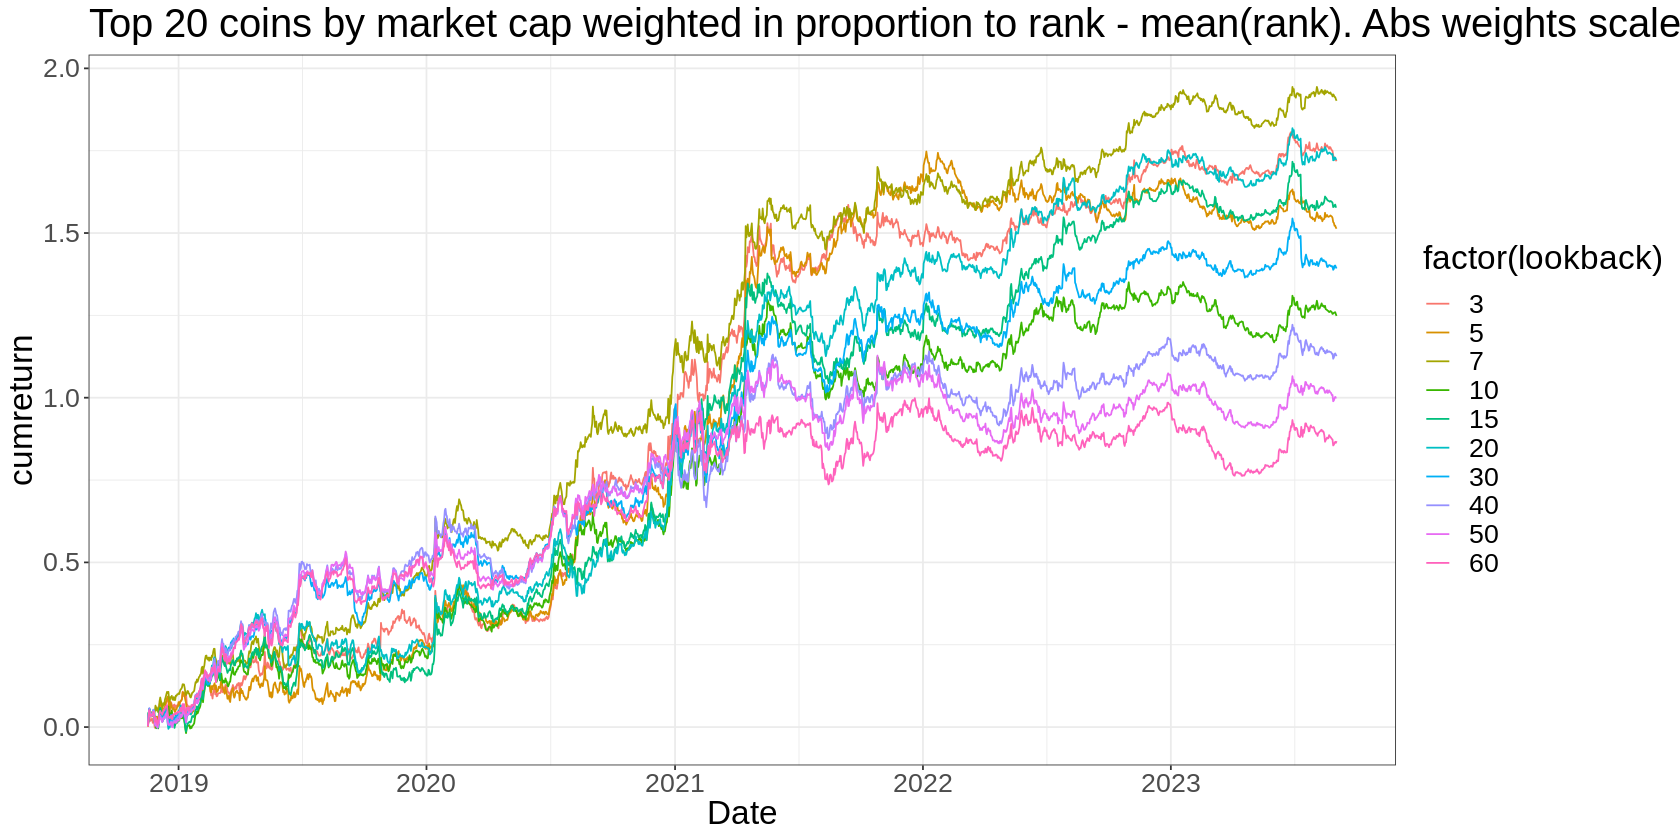

In [ ]:
universe20 <- create_binance_universe(daily_prices, market_cap, n=20, min_constituents=20, stables=stables, to_remove=to_remove)

lookback_returns20 <- universe20 %>%
  group_by(Ticker) %>%
  arrange(Date) %>%
  # Calculate 20d momentum feature
  mutate(
    # Give columns the name of the lookback for pivoting long to tidy format later
    "3" = Close / lag(Close, n = 3) - 1,
    "5" = Close / lag(Close, n = 5) - 1,
    "7" = Close / lag(Close, n = 7) - 1,
    "10" = Close / lag(Close, n = 10) - 1,
    "15" = Close / lag(Close, n = 15) - 1,
    "20" = Close / lag(Close, n = 20) - 1,
    "30" = Close / lag(Close, n = 30) - 1,
    "40" = Close / lag(Close, n = 40) - 1,
    "50" = Close / lag(Close, n = 50) - 1,
    "60" = Close / lag(Close, n = 60) - 1,
  ) %>%
  # Calculate next day returns
  mutate(fwd_log_return = log(lead(Close) / Close),
         fwd_simple_return = lead(Close) / Close - 1) %>%
  na.omit() %>%
  ungroup() %>%
  # Convert to tidy format
  pivot_longer("3":"60", names_to = "lookback", values_to = "momo") %>%
  mutate(lookback = as.numeric(lookback))

 lookback_returns20 %>%
  filter(is_index) %>%
  group_by(lookback, Date) %>%
  mutate(
    rank = row_number(momo),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = fwd_simple_return * scaled_weight
  ) %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  group_by(lookback) %>%
  arrange(Date) %>%
  mutate(cumreturn = cumsum(log_factor_return)) %>%
  ggplot(aes(x=Date, y=cumreturn, color = factor(lookback))) +
    geom_line() +
    ggtitle('Top 20 coins by market cap weighted in proportion to rank - mean(rank). Abs weights scaled to 1. Cum log returns')

lookback_returns20 %>%
  filter(is_index) %>%
  group_by(lookback, Date) %>%
  mutate(
    rank = row_number(momo),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = fwd_simple_return * scaled_weight
  ) %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  group_by(lookback) %>%
  summarise(
    meanreturn = mean(log_factor_return) * 365,
    volreturn = sd(log_factor_return) * sqrt(365),
    ir = meanreturn / volreturn
  ) %>%
  arrange(desc(meanreturn))

# SMA RATIO


In [ ]:
returns <- universe %>%
  group_by(Ticker) %>%
  arrange(Date) %>%
  # Calculate sma310 momentum feature
  mutate(
    smaratio310 = roll_meanr(Close, n = 3) / roll_meanr(Close, n = 10)-1,
    lagsmaratio310 = lag(smaratio310)
  ) %>%
  # Calculate next day returns
  mutate(
    fwd_log_return = log(lead(Close) / Close),
    fwd_simple_return = lead(Close) / Close - 1
  ) %>%
  na.omit() %>%
  ungroup()

  head(returns, 10)

Date,Ticker,Close,Price,Volume,MarketCapUSD,cap_rank,is_index,smaratio310,lagsmaratio310,fwd_log_return,fwd_simple_return
<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
2017-08-27,BTC,4315.16,4416.5900,1494478105,71990197748,1,FALSE,0.02955108,0.02990046,0.008804369,0.008843241
2017-08-27,ETH,338.81,337.8332,548394983,31890326608,2,FALSE,0.05597120,0.05070070,0.028170057,0.028570585
2017-08-28,BTC,4353.32,4224.6400,1753622902,71467851471,1,FALSE,0.02764572,0.02955108,0.053350754,0.054799555
2017-08-28,ETH,348.49,344.3153,853799014,32662732770,2,FALSE,0.05861871,0.05597120,0.072008969,0.074664983
2017-08-29,BTC,4591.88,4466.6683,2085864444,73944224708,1,FALSE,0.03960652,0.02764572,-0.009623938,-0.009577776
2017-08-29,ETH,374.51,359.8237,913974307,33953361293,2,FALSE,0.07621405,0.05861871,0.027624829,0.028009933
2017-08-30,BTC,4547.90,4564.0260,2360344931,75310050770,1,FALSE,0.04853321,0.03960652,0.032258419,0.032784362
2017-08-30,ETH,385.00,388.7480,1388277535,35451533279,2,FALSE,0.09414917,0.07621405,-0.001065503,-0.001064935
2017-08-31,BTC,4697.00,4646.7147,1864586486,76665580139,1,FALSE,0.05904655,0.04853321,0.030645458,0.031119864


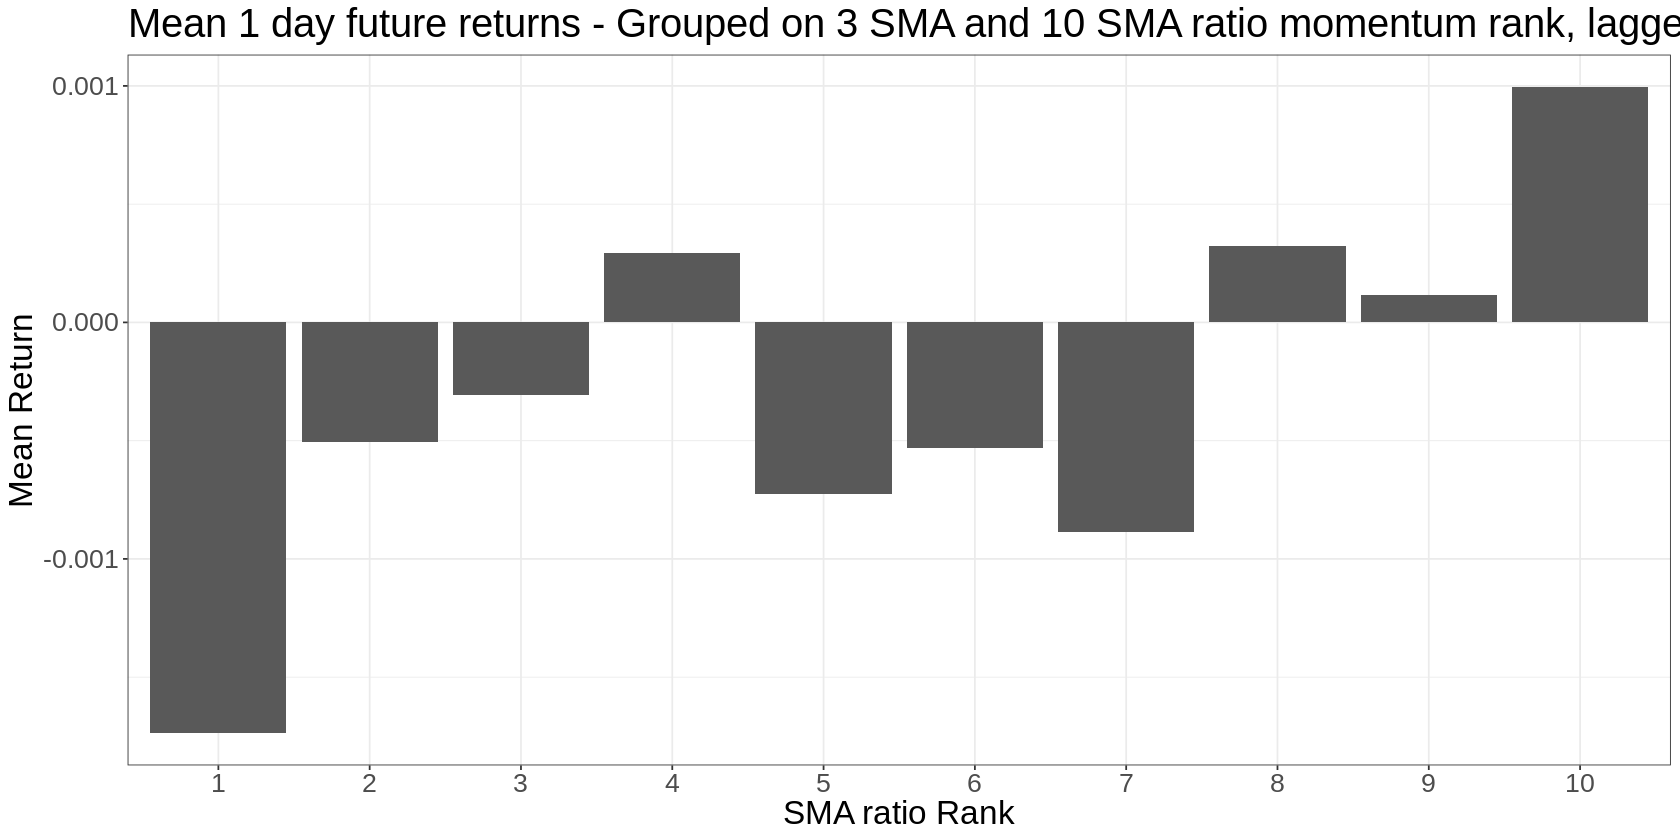

In [ ]:
returns %>%
  filter(is_index == TRUE) %>%
  group_by(Date) %>%
  mutate(lagrank = factor(row_number(lagsmaratio310))) %>%
  group_by(lagrank) %>%
  summarise(mean_fwd_log_ret = mean(fwd_log_return)) %>%
  ggplot(aes(x=lagrank, y=mean_fwd_log_ret)) +
  geom_bar(stat='identity') +
  labs(
    title = 'Mean 1 day future returns - Grouped on 3 SMA and 10 SMA ratio momentum rank, lagged 1 day',
    x = 'SMA ratio Rank',
    y = 'Mean Return'
  )

`summarise()` has grouped output by 'lookback'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'lookback'. You can override using the
`.groups` argument.


lookback,meanreturn,volreturn,ir
<dbl>,<dbl>,<dbl>,<dbl>
530,0.33051036,0.2617860,1.26252101
320,0.32829043,0.2607158,1.25918882
330,0.32405845,0.2610822,1.24121216
1030,0.30148517,0.2562908,1.17634008
520,0.30010444,0.2591574,1.15800072
1040,0.28109024,0.2514392,1.11792512
540,0.27830226,0.2586816,1.07584859
560,0.27693122,0.2491147,1.11166157
1540,0.27669753,0.2462890,1.12346703


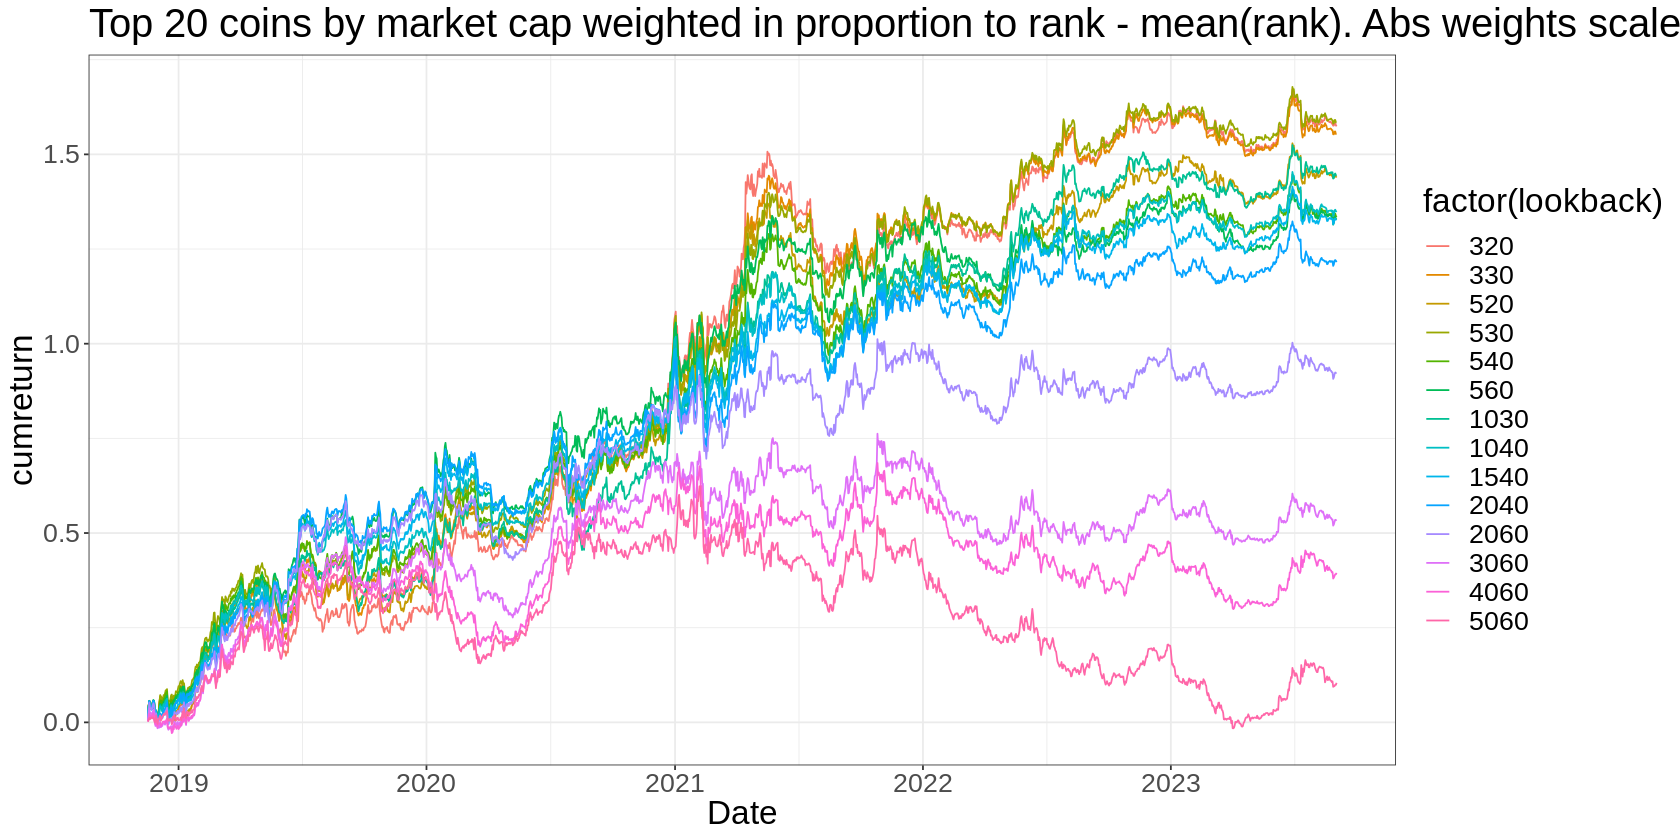

In [ ]:
lookback_returns20 <- universe20 %>%
  group_by(Ticker) %>%
  arrange(Date) %>%
  # Calculate SMA momentum feature
  mutate(
    # Give columns the name of the lookback for pivoting long to tidy format later
    "310" = roll_meanr(Close, n = 3) / roll_meanr(Close, n = 10)-1,
    "320" = roll_meanr(Close, n = 3) / roll_meanr(Close, n = 20) - 1,
    "330" = roll_meanr(Close, n = 3) / roll_meanr(Close, n = 30) - 1,
    "520" = roll_meanr(Close, n = 5) / roll_meanr(Close, n = 20) - 1,
    "530" = roll_meanr(Close, n = 5) / roll_meanr(Close, n = 30) - 1,
    "540" = roll_meanr(Close, n = 5) / roll_meanr(Close, n = 40) - 1,
    "560" = roll_meanr(Close, n = 5) / roll_meanr(Close, n = 60) - 1,
    "1030" = roll_meanr(Close, n = 10) / roll_meanr(Close, n = 30) - 1,
    "1040" = roll_meanr(Close, n = 10) / roll_meanr(Close, n = 40) - 1,
    "1540" = roll_meanr(Close, n = 15) / roll_meanr(Close, n = 40) - 1,
    "2040" = roll_meanr(Close, n = 20) / roll_meanr(Close, n = 40) - 1,
    "2060" = roll_meanr(Close, n = 20) / roll_meanr(Close, n = 60) - 1,
    "3060" = roll_meanr(Close, n = 30) / roll_meanr(Close, n = 60) - 1,
    "4060" = roll_meanr(Close, n = 40) / roll_meanr(Close, n = 60) - 1,
    "5060" = roll_meanr(Close, n = 50) / roll_meanr(Close, n = 60) - 1,
  ) %>%
  # Calculate next day returns
  mutate(fwd_log_return = log(lead(Close) / Close),
         fwd_simple_return = lead(Close) / Close - 1) %>%
  na.omit() %>%
  ungroup() %>%
  # Convert to tidy format
  pivot_longer("320":"5060", names_to = "lookback", values_to = "momo") %>%
  mutate(lookback = as.numeric(lookback))

 lookback_returns20 %>%
  filter(is_index) %>%
  group_by(lookback, Date) %>%
  mutate(
    rank = row_number(momo),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = fwd_simple_return * scaled_weight
  ) %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  group_by(lookback) %>%
  arrange(Date) %>%
  mutate(cumreturn = cumsum(log_factor_return)) %>%
  ggplot(aes(x=Date, y=cumreturn, color = factor(lookback))) +
    geom_line() +
    ggtitle('Top 20 coins by market cap weighted in proportion to rank - mean(rank). Abs weights scaled to 1. Cum log returns')

lookback_returns20 %>%
  filter(is_index) %>%
  group_by(lookback, Date) %>%
  mutate(
    rank = row_number(momo),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = fwd_simple_return * scaled_weight
  ) %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  group_by(lookback) %>%
  summarise(
    meanreturn = mean(log_factor_return) * 365,
    volreturn = sd(log_factor_return) * sqrt(365),
    ir = meanreturn / volreturn
  ) %>%
  arrange(desc(meanreturn))

Interesting that the slower momentum doesn't perform well at all. Let's check out why

In [ ]:
returns <- universe %>%
  group_by(Ticker) %>%
  arrange(Date) %>%
  # Calculate sma5060 momentum feature
  mutate(
    sma5060 = roll_meanr(Close, n = 50) / roll_meanr(Close, n = 60) - 1,,
    lagsma5060 = lag(sma5060)
  ) %>%
  # Calculate next day returns
  mutate(
    fwd_log_return = log(lead(Close) / Close),
    fwd_simple_return = lead(Close) / Close - 1
  ) %>%
  na.omit() %>%
  ungroup()

  head(returns, 10)

Date,Ticker,Close,Price,Volume,MarketCapUSD,cap_rank,is_index,sma5060,lagsma5060,fwd_log_return,fwd_simple_return
<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
2017-10-17,BTC,5599.99,5587.3008,1674450923,93184090990,1,FALSE,0.007754392,0.006719764,-0.009489543,-0.009444660
2017-10-17,ETH,314.87,323.6321,407771701,30886884254,2,FALSE,-0.004887899,-0.002891588,-0.006148376,-0.006129514
2017-10-18,BTC,5547.10,5157.8665,1765142429,89892381122,1,FALSE,0.007708951,0.007754392,0.021598103,0.021833030
2017-10-18,ETH,312.94,293.6253,435905774,29115475327,2,FALSE,-0.008231946,-0.004887899,-0.022818611,-0.022560235
2017-10-19,BTC,5668.21,5642.4280,2003847685,93912007254,1,FALSE,0.006768122,0.007708951,0.056202531,0.057811902
2017-10-19,ETH,305.88,309.6297,401589562,29531532227,2,FALSE,-0.013490286,-0.008231946,-0.009328058,-0.009284687
2017-10-20,BTC,5995.90,5771.8363,1661760080,96682383088,1,FALSE,0.006389441,0.006768122,0.015406320,0.015525609
2017-10-20,ETH,303.04,306.1633,267373144,29212640755,2,FALSE,-0.019068160,-0.013490286,-0.009682415,-0.009635692
2017-10-21,BTC,6088.99,6188.3350,2357226249,101572370054,1,FALSE,0.004931551,0.006389441,-0.024768038,-0.024463827


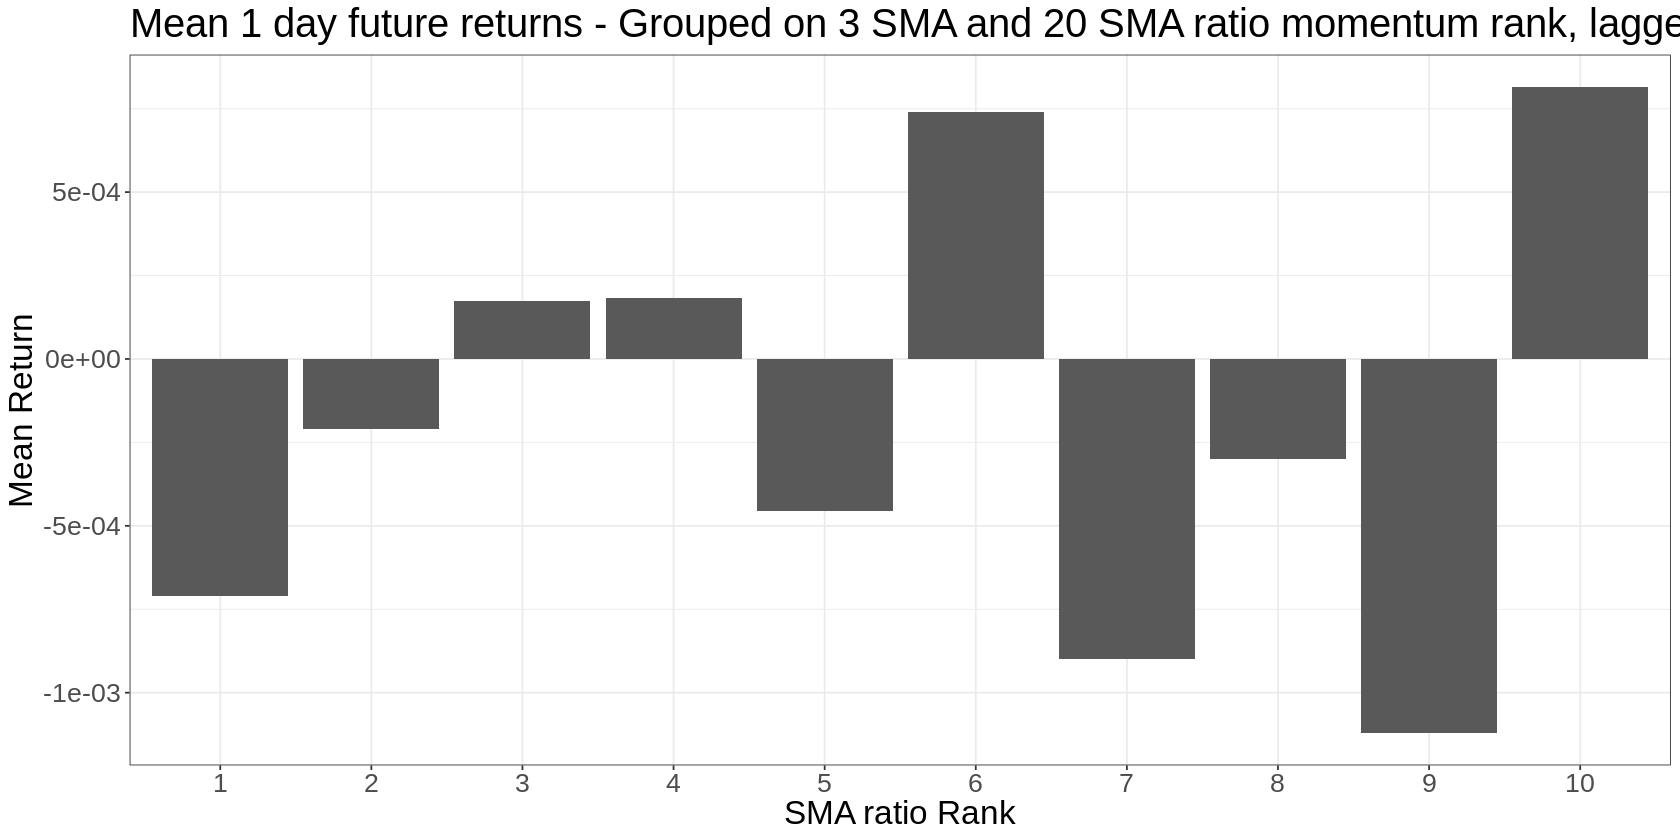

In [ ]:
returns %>%
  filter(is_index == TRUE) %>%
  group_by(Date) %>%
  mutate(lagrank = factor(row_number(lagsma5060))) %>%
  group_by(lagrank) %>%
  summarise(mean_fwd_log_ret = mean(fwd_log_return)) %>%
  ggplot(aes(x=lagrank, y=mean_fwd_log_ret)) +
  geom_bar(stat='identity') +
  labs(
    title = 'Mean 1 day future returns - Grouped on 3 SMA and 20 SMA ratio momentum rank, lagged 1 day',
    x = 'SMA ratio Rank',
    y = 'Mean Return'
  )

# Percentile factor

`QuantTools::roll_percent_rank` not available for the current version of R. We could implement our own version of this in the future.

In [ ]:
# returns <- universe %>%
#   group_by(Ticker) %>%
#   arrange(Date) %>%
#   # Calculate rolling_percentile_50  feature
#   mutate( rolling_percentile_50 = roll_percent_rank(Close, n = 50) ,
#          lagrolling_percentile_50 = lag(rolling_percentile_50)) %>%
#   # Calculate next day returns
#   mutate(fwd_log_return = log(lead(Close) / Close),
#          fwd_simple_return = lead(Close) / Close - 1) %>%
#   na.omit() %>%
#   ungroup()

#   returns %>% head(10)

In [ ]:
# returns %>%
#   filter(is_index == TRUE) %>%
#   group_by(Date) %>%
#   mutate(lagrank50 = factor(row_number(lagrolling_percentile_50))) %>%
#   group_by(lagrank50) %>%
#   summarise(mean_fwd_log_ret = mean(fwd_log_return)) %>%
#   ggplot(aes(x=lagrank50, y=mean_fwd_log_ret)) +
#   geom_bar(stat='identity') +
#   labs(
#     title = 'Mean 1 day future returns - Grouped on rolling 50 window of percentile rank , lagged 1 day',
#     x = 'Rolling Percentile Rank',
#     y = 'Mean Return'
#   )

In [ ]:
# lookback_returns20 <- universe20 %>%
#   group_by(Ticker) %>%
#   arrange(Date) %>%
#   # Calculate 20d momentum feature
#   mutate(

#     # Give columns the name of the lookback for pivoting long to tidy format later
#     "10"  = roll_percent_rank(Close, n = 10),
#     "20"  = roll_percent_rank(Close, n = 20),
#     "30"  = roll_percent_rank(Close, n = 30),
#     "40" = roll_percent_rank(Close, n = 40),
#     "50"  = roll_percent_rank(Close, n = 50),
#     "60"  = roll_percent_rank(Close, n = 60),
#   ) %>%
#   # Calculate next day returns
#   mutate(fwd_log_return = log(lead(Close) / Close),
#          fwd_simple_return = lead(Close) / Close - 1) %>%
#   na.omit() %>%
#   ungroup() %>%
#   # Convert to tidy format
#   pivot_longer("10":"60", names_to = "lookback", values_to = "momo") %>%
#   mutate(lookback = as.numeric(lookback))

#  lookback_returns20 %>%
#   filter(is_index) %>%
#   group_by(lookback, Date) %>%
#   mutate(
#     rank = row_number(momo),
#     weight = rank - mean(rank),
#     scaled_weight = weight / sum(abs(weight)),
#     weighted_fwd_returns = fwd_simple_return * scaled_weight
#   ) %>%
#   summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
#   group_by(lookback) %>%
#   arrange(Date) %>%
#   mutate(cumreturn = cumsum(log_factor_return)) %>%
#   ggplot(aes(x=Date, y=cumreturn, color = factor(lookback))) +
#     geom_line() +
#     ggtitle('Top 20 coins by market cap weighted in proportion to rank - mean(rank). Abs weights scaled to 1. Cum log returns')

# lookback_returns20 %>%
#   filter(is_index) %>%
#   group_by(lookback, Date) %>%
#   mutate(
#     rank = row_number(momo),
#     weight = rank - mean(rank),
#     scaled_weight = weight / sum(abs(weight)),
#     weighted_fwd_returns = fwd_simple_return * scaled_weight
#   ) %>%
#   summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
#   group_by(lookback) %>%
#   summarise(
#     meanreturn = mean(log_factor_return) * 365,
#     volreturn = sd(log_factor_return) * sqrt(365),
#     ir = meanreturn / volreturn
#   ) %>%
#   arrange(desc(meanreturn))

# Summary

We see a persistent and robust cross-sectional momentum effect.

It is probably best harnessed with an ensemble of momentum features and parameters.